# setup

In [1]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
#PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/OTU-TAXA-FOUNDATION").resolve()
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

# If you still use these helper functions in your old test notebook,
# keep them. Otherwise we can remove later.
from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed




# laod model

In [2]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External (heavy) dataset location (outside repo)
# Use EXACT same path construction as training
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # prefer meta if saved

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

AFFECTED_OTU_IDS_PATH = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_incomplete_species_fromOTUS_predictions/affected_otu_ids_from_removed_species.txt"

# ---------------------------
# Rebuild EXACT split used in training
# ---------------------------
seed   = meta.get("seed", 123)
TEST_N = meta.get("TEST_N", 20_000)
VAL_N  = meta.get("VAL_N", 20_000)

set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(TEST_N, N)
VAL_N  = min(VAL_N, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)




[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


In [3]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names (NEW layout)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
experiment_name = "runs_microbeatlas"     # runs_microbeatlas/<run_name>

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# Full MicrobeAtlas dataset path (EXACT training logic)
# IMPORTANT: prefer meta['dataset_folder_name'] if present to avoid mismatches
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"

# NOTE: this is the only functional change I recommend here:
#       use meta.json to pick the dataset folder name when available.
with open(META_PATH, "r") as f:
    meta = json.load(f)

dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSONL = OUT_DIR / "pred_affected_taxonomy.jsonl"

# ---------------------------
# 1) meta.json strict load (already loaded above)
# ---------------------------
mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# 2) dataset sizes + strict consistency checks
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

# specials (exact same convention as training)
pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")

M_np = np.load(UNK_M_PATH)  # [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)  # [T_base]
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn (keeps model construction identical to training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly and strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,   # IMPORTANT for parity with training
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")

# -----------------------------------
# Build tax_id2name mapping (GLOBAL)
# -----------------------------------
if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}
elif isinstance(tax_vocab_unk, dict):
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}
else:
    raise TypeError(f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}")

if len(tax_id2name) != T_base:
    raise ValueError(f"tax_id2name size mismatch: len={len(tax_id2name)} vs T_base={T_base}")

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] dataset_dir=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] O=62200, T_real=6929, T_base=6935, n_taxa=6937
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas/pretrain_hier_joint_unk_taxa/pred_affected_taxonomy.jsonl
[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# predictions

In [4]:
def load_affected_otu_ids_txt(path: str, otu_name2id: dict) -> Set[int]:
    """
    Load affected OTUs from a text file.
    Supports:
      - integer OTU ids (as strings)
      - OTU names like '90_1015;96_21955;97_71802'
    """
    ids = set()
    missing = []

    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            # Case 1: already an integer OTU id
            if s.isdigit():
                ids.add(int(s))
                continue

            # Case 2: OTU name → map to id
            if otu_name2id is not None and s in otu_name2id:
                ids.add(int(otu_name2id[s]))
            else:
                missing.append(s)

    if missing:
        print(
            f"[WARN] {len(missing)} affected OTUs could not be mapped to dataset OTU ids "
            f"(showing first 10): {missing[:10]}"
        )

    return ids


In [5]:
# --------------------------------------------------------- 
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)


# ---------------------------------------------------------
# 1) OTU vocab mappings (optional; keep as-is)
# ---------------------------------------------------------
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")


affected_otu_ids = load_affected_otu_ids_txt(
    AFFECTED_OTU_IDS_PATH,
    otu_name2id=otu_name2id,
)

print(f"[AFFECTED] preview: {sorted(list(affected_otu_ids))[:20]}")


# ---------------------------------------------------------
# 2) Sanity check dataset sizes (parity with model block)
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")

# ---------------------------------------------------------
# 3) Build OTU pool from test_ds (Subset) (keep as-is)
# ---------------------------------------------------------
def build_otu_pool_from_subset(subset_ds, otu_key="otus", probe=None, return_counts=True):
    pool = set()
    counts = Counter()
    n_seen = 0

    L = len(subset_ds)
    limit = L if probe is None else min(L, int(probe))

    for i in range(limit):
        rec = subset_ds[i]
        if not isinstance(rec, dict):
            continue
        otus = rec.get(otu_key, [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        for o in otus:
            oi = int(o.item() if torch.is_tensor(o) else o)
            pool.add(oi)
            if return_counts:
                counts[oi] += 1
        n_seen += 1

    return (pool, counts, n_seen) if return_counts else (pool, n_seen)

otu_pool, otu_counts, n_seen = build_otu_pool_from_subset(test_ds, otu_key="otus", probe=None, return_counts=True)

print(f"[POOL] scanned test samples: {n_seen}")
print(f"[POOL] unique OTUs in test set: {len(otu_pool)}")
print(f"[POOL] preview OTU IDs: {sorted(list(otu_pool))[:15]}")

# ---------------------------------------------------------
# 4) REPLACE random OTUs with: affected OTUs intersect test OTU pool
# ---------------------------------------------------------
mask_otu_ids = sorted(list(affected_otu_ids.intersection(otu_pool)))

print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(mask_otu_ids):,}")
if len(affected_otu_ids) > 0:
    print(f"[AFFECTED∩TEST] coverage: {len(mask_otu_ids)/float(len(affected_otu_ids)):.2%} "
          f"(of all affected OTUs)")
print(f"[AFFECTED∩TEST] preview: {mask_otu_ids[:20]}")

if len(mask_otu_ids) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU id space alignment between affected list and OTUTaxaDataset."
    )

# Optional: frequencies in test set (kept from your original logic)
freq_preview = [(oid, otu_counts.get(oid, 0)) for oid in mask_otu_ids[:15]]
print("[AFFECTED∩TEST] frequency preview (otu_id, count_in_test_scan):")
print(freq_preview)

# ---------------------------------------------------------
# 5) Descendant matrix + rank_idx loading
# IMPORTANT: you already loaded these in the earlier model block.
# Keep this ONLY if you intentionally want a second check on CPU.
# Otherwise, delete to avoid redundant loads.
# ---------------------------------------------------------
# If you keep it, it is functionally OK, but redundant.

if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)


[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[WARN] 788 affected OTUs could not be mapped to dataset OTU ids (showing first 10): ['90_1015;96_21955;97_71802', '90_10304;96_44834;97_57458', '90_1043;96_25689;97_76253', '90_104;96_21964;97_40372', '90_104;96_50355;97_64824', '90_104;96_59769;97_77397', '90_10518;96_45799;97_58769', '90_10612;96_46197;97_59287', '90_10634;96_46301;97_59430', '90_10634;96_64931;97_84238']
[AFFECTED] preview: [179, 433, 584, 808, 914, 981, 1236, 1306, 1388, 1666, 1710, 1718, 1781, 1796, 1811, 1911, 1950, 1981, 2030, 2086]
[INFO] Eval setup: O=62200, T_real=6929, T_base=6935
[POOL] scanned test samples: 20000
[POOL] unique OTUs in test set: 59446
[POOL] preview OTU IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[AFFECTED∩TEST] affected OTUs present in test set: 692
[AFFECTED∩TEST] coverage: 94.79% (of all

In [6]:
import torch

def make_tax_only_mask_collator(dataset, affected_ids, *, T_base: int, max_len=None):
    O = dataset.O
    pad_otu_id, mask_otu_id = O, O + 1

    pad_tax_id, mask_tax_id = T_base, T_base + 1  # IMPORTANT (matches model)

    affected_ids = set(map(int, affected_ids))

    def collate(batch):
        lengths = [len(b["otus"]) for b in batch]
        L = max_len if max_len is not None else max(lengths)
        B = len(batch)

        input_otus = torch.full((B, L), pad_otu_id, dtype=torch.long)
        input_taxa = torch.full((B, L), pad_tax_id, dtype=torch.long)
        attention_mask = torch.zeros((B, L), dtype=torch.bool)

        masked_positions = []
        sample_ids = []
        true_taxa = []

        for i, rec in enumerate(batch):
            otus = torch.tensor(rec["otus"], dtype=torch.long)
            taxa = torch.tensor(rec["taxa"], dtype=torch.long)

            L_i = min(L, len(otus))
            input_otus[i, :L_i] = otus[:L_i]
            input_taxa[i, :L_i] = taxa[:L_i]
            attention_mask[i, :L_i] = True

            aff_mask = torch.tensor(
                [int(int(x) in affected_ids) for x in otus[:L_i]],
                dtype=torch.bool
            )

            input_taxa[i, :L_i][aff_mask] = mask_tax_id

            pos_idx = torch.nonzero(aff_mask, as_tuple=False).view(-1).tolist()
            masked_positions.append(pos_idx)

            sample_ids.append(rec["sample_id"])

            # FIX: store the aligned/truncated gold taxonomy for this sample
            gold = torch.full((L,), pad_tax_id, dtype=torch.long)
            gold[:L_i] = taxa[:L_i]
            true_taxa.append(gold)

        return {
            "input_otus": input_otus,
            "input_taxa": input_taxa,
            "attention_mask": attention_mask,
            "masked_positions": masked_positions,
            "sample_ids": sample_ids,
            "true_taxa": true_taxa,  # list[Tensor(L,)]
        }

    return collate


In [ ]:
# -------------------------
# Output (UPDATED: distinguish affected vs random)
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Tag this experiment explicitly
AFFECTED_TAG = "affected_removed_species_20pct_seed123"

OUT_JSONL_AFFECTED = PRED_DIR / f"pred_{AFFECTED_TAG}_taxonomy_per_rank.jsonl"
if OUT_JSONL_AFFECTED.exists():
    OUT_JSONL_AFFECTED.unlink()

print(f"[INFO] Writing AFFECTED-OTU predictions to: {OUT_JSONL_AFFECTED}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# -------------------------
# Choose AFFECTED OTUs 
# -------------------------
# You should already have:
#   affected_otu_ids : Set[int]   (mapped to dataset id space)
#   otu_pool         : Set[int]   (from test set scan)
# We restrict to those actually appearing in test set:
affected_in_test = set(affected_otu_ids).intersection(otu_pool)

print(f"[AFFECTED] total affected OTUs loaded: {len(affected_otu_ids):,}")
print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(affected_in_test):,}")
print(f"[AFFECTED∩TEST] preview: {sorted(list(affected_in_test))[:15]}")

if len(affected_in_test) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU-id mapping and the affected list definition."
    )

mask_otu_ids = affected_in_test  # name kept for parity with old loop

# -------------------------
# KEEP existing collator (unchanged), but use affected IDs
# -------------------------
max_len = meta.get("max_len", 500)  # keep as before
collate = make_tax_only_mask_collator(ds, mask_otu_ids, T_base=T_base, max_len=500)

# -------------------------
# Batch iterator over test_ds only
# Same logic: keep only samples that contain ≥1 target OTU
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    for i in range(len(subset)):
        rec = subset[i]

        otus = rec.get("otus", [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()

        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Helpers for name mapping (robust)
# -------------------------
def _tax_name(tid: int):
    if "tax_id2name" in globals() and tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    if "tax_vocab_unk" in globals() and tax_vocab_unk is not None:
        if isinstance(tax_vocab_unk, dict):
            return tax_vocab_unk.get(str(int(tid)), tax_vocab_unk.get(int(tid), f"<id:{int(tid)}>"))
        if isinstance(tax_vocab_unk, list) and 0 <= tid < len(tax_vocab_unk):
            return tax_vocab_unk[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if "otu_id2name" in globals() and otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop (UNCHANGED except output path variable)
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_AFFECTED, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(
            test_ds, BATCH_SIZE, mask_otu_ids
        ):
            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model forward output does not contain taxonomy logits.")

            # block PAD_TAX and MASK_TAX (indices T_base, T_base+1)
            if pad_tax_id < logits_tax.size(-1):
                logits_tax[:, :, pad_tax_id] = float("-inf")
            if mask_tax_id < logits_tax.size(-1):
                logits_tax[:, :, mask_tax_id] = float("-inf")

            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    logits_vec = logits_tax[bi, pos]
                    logits_base = logits_vec[:T_base]

                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {
                            "tax_id": int(pid),
                            "tax_name": _tax_name(int(pid)),
                        }

                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    otu_id = int(batch["input_otus"][bi, pos].item())

                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                        # Optional but useful provenance tag:
                        "experiment_tag": AFFECTED_TAG,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote AFFECTED predictions to: {OUT_JSONL_AFFECTED}")
print(f"[INFO] samples with ≥1 masked affected OTU: {total_samples}")
print(f"[INFO] total masked positions (affected OTUs): {total_masked_positions}")


[INFO] Writing AFFECTED-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_affected_removed_species_20pct_seed123_taxonomy_per_rank.jsonl
[AFFECTED] total affected OTUs loaded: 730
[AFFECTED∩TEST] affected OTUs present in test set: 692
[AFFECTED∩TEST] preview: [179, 433, 584, 808, 914, 981, 1236, 1306, 1388, 1666, 1710, 1718, 1781, 1796, 1811]
[INFO] TEST filtering: subset size=20000 | matched with ≥1 target OTU: 10561
[DONE] wrote AFFECTED predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_affected_removed_species_20pct_seed123_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked affected OTU: 10513
[INFO] total masked positions (affected OTUs): 24200


In [8]:
import re

# -----------------------------
# Diagnostics for affected OTUs
# -----------------------------

print("[DEBUG] AFFECTED_OTU_IDS_PATH =", AFFECTED_OTU_IDS_PATH)

# 1) Read raw affected file
with open(AFFECTED_OTU_IDS_PATH, "r") as f:
    raw_lines = [ln.strip() for ln in f if ln.strip()]

print("[DEBUG] raw affected entries in file:", len(raw_lines))
print("[DEBUG] raw preview:", raw_lines[:5])

# 2) Normalization helper (same logic we should use everywhere)
def normalize_otu_name(s: str) -> str:
    return re.sub(r"\s+", "", str(s)).strip().strip('"').strip("'")

# 3) Try mapping to dataset OTU ids
mapped_ids = set()
missing = []

for s in raw_lines:
    ss = normalize_otu_name(s)

    # case A: already integer
    if ss.isdigit():
        mapped_ids.add(int(ss))
        continue

    # case B: OTU name -> dataset id
    if otu_name2id is not None and ss in otu_name2id:
        mapped_ids.add(int(otu_name2id[ss]))
    else:
        missing.append(s)

print("\n[DEBUG] mapping results:")
print("  mapped affected OTUs:", len(mapped_ids))
print("  missing / unmapped OTUs:", len(missing))

if missing:
    print("  missing preview (first 10):")
    for x in missing[:10]:
        print("   ", x)

# 4) Dataset-level sanity
print("\n[DEBUG] dataset OTU vocab size (ds.O):", ds.O)

# 5) Intersection with test set
mapped_in_test = mapped_ids & otu_pool
print("\n[DEBUG] mapped affected OTUs in test set:", len(mapped_in_test))

if mapped_ids:
    print(
        "[DEBUG] coverage in test: {:.2%}".format(
            len(mapped_in_test) / len(mapped_ids)
        )
    )

# 6) Final consistency check
print("\n[SUMMARY]")
print(f"  affected (file)        : {len(raw_lines)}")
print(f"  affected (mapped)      : {len(mapped_ids)}")
print(f"  affected (mapped∩test) : {len(mapped_in_test)}")


[DEBUG] AFFECTED_OTU_IDS_PATH = /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_incomplete_species_fromOTUS_predictions/affected_otu_ids_from_removed_species.txt
[DEBUG] raw affected entries in file: 1518
[DEBUG] raw preview: ['90_1015;96_21955;97_71802', '90_1015;96_55630;97_71800', '90_10304;96_44834;97_57458', '90_1043;96_25689;97_76253', '90_1049;96_12459;97_15129']

[DEBUG] mapping results:
  mapped affected OTUs: 730
  missing / unmapped OTUs: 788
  missing preview (first 10):
    90_1015;96_21955;97_71802
    90_10304;96_44834;97_57458
    90_1043;96_25689;97_76253
    90_104;96_21964;97_40372
    90_104;96_50355;97_64824
    90_104;96_59769;97_77397
    90_10518;96_45799;97_58769
    90_10612;96_46197;97_59287
    90_10634;96_46301;97_59430
    90_10634;96_64931;97_84238

[DEBUG] dataset OTU vocab size (ds.O): 62200

[DEBUG] mapped affected OTUs in test set: 692
[DEBUG] coverage in test: 94.79%

[SUMMARY]
  affec

# print predictions

In [9]:
from typing import Union, Tuple, Optional, Set
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

def evaluate_and_plot_predictions_multilabel(
    jsonl_path: Union[str, Path],
    title_prefix: str = "Per-OTU Accuracy vs # Predictions (multilabel TEST)",
    make_plot: bool = True,
    # Optional: if you want to enforce filtering (e.g., sanity check)
    test_ids: Optional[Set[str]] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame, dict, Optional[plt.Figure]]:
    """
    Multilabel-aware evaluation:

    For each prediction row:
      - Infer the TRUE rank letter from `true_tax_name` (k,p,c,o,f,g,s).
      - Take the model's prediction at that SAME rank from `pred_by_rank[rank]`.
      - Correct if predicted tax_id == true_tax_id.

    Aggregate per OTU and plot Accuracy vs # predictions per OTU (log X).

    Expected JSONL columns:
      - sample_id, otu_name
      - true_tax_id, true_tax_name
      - pred_by_rank: dict like {"g": {"tax_id": ..., "tax_name": ...}, ...}
    """
    jsonl_path = Path(jsonl_path)

    # --- load predictions ---
    df = pd.read_json(str(jsonl_path), lines=True)

    # --- optional filter by provided test IDs ---
    if test_ids is not None:
        test_ids = set(map(str, test_ids))
        df["sample_id"] = df["sample_id"].astype(str)
        df = df[df["sample_id"].isin(test_ids)].copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No predictions to evaluate (empty after loading/filtering).")
        return df, pd.DataFrame(), summary, None

    # --- infer TRUE rank letter from true_tax_name ---
    def _true_rank_letter(name):
        if not isinstance(name, str) or len(name) == 0:
            return None
        ch = name[0].lower()
        return ch if ch in {"k","p","c","o","f","g","s"} else None

    df["true_rank"] = df["true_tax_name"].apply(_true_rank_letter)
    df = df.dropna(subset=["true_rank"]).copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No rows with a valid rank letter in true_tax_name.")
        return df, pd.DataFrame(), summary, None

    # --- extract predicted id at that same rank from pred_by_rank ---
    def _pred_id_for_true_rank(row):
        true_rank = row["true_rank"]
        pb = row.get("pred_by_rank", None)
        if not isinstance(pb, dict):
            return None
        pr = pb.get(true_rank, None)
        if not isinstance(pr, dict):
            return None
        try:
            return int(pr.get("tax_id"))
        except Exception:
            return None

    df["pred_rank_id"] = df.apply(_pred_id_for_true_rank, axis=1)
    df = df.dropna(subset=["pred_rank_id"]).copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No rows with a usable pred_by_rank entry for the true rank.")
        return df, pd.DataFrame(), summary, None

    df["pred_rank_id"] = df["pred_rank_id"].astype(int)

    # --- correctness ---
    df["correct"] = (df["pred_rank_id"] == df["true_tax_id"]).astype(int)

    # --- per-OTU aggregation ---
    g = (
        df.groupby("otu_name")
          .agg(accuracy=("correct", "mean"),
               n_pred=("correct", "size"),
               n_unique_samples=("sample_id", "nunique"))
          .reset_index()
    )

    fig = None
    if g.empty:
        summary = {
            "n_samples": int(df["sample_id"].nunique()),
            "n_preds": len(df),
            "n_otus": 0,
            "n_correct": int(df["correct"].sum()),
            "micro_acc": float("nan"),
            "mean_per_otu": float("nan"),
        }
        print("[WARN] No per-OTU groups after aggregation.")
        return df, g, summary, fig

    # --- summary metrics ---
    total_preds = len(df)
    n_correct   = int(df["correct"].sum())
    micro_acc   = (n_correct / total_preds) if total_preds > 0 else float("nan")
    mean_per_otu = float(g["accuracy"].mean())
    n_samples = int(df["sample_id"].nunique())
    n_otus    = int(g.shape[0])

    summary = {
        "n_samples": n_samples,
        "n_preds": total_preds,
        "n_otus": n_otus,
        "n_correct": n_correct,
        "micro_acc": micro_acc,
        "mean_per_otu": mean_per_otu,
    }

    # --- plot ---
    if make_plot:
        g_sorted = g.sort_values(
            ["n_unique_samples", "n_pred", "accuracy"],
            ascending=[False, False, False]
        )
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.scatter(g_sorted["n_pred"], g_sorted["accuracy"], alpha=0.2)
        ax.set_xlabel("# predictions per OTU (n_pred) [log]")
        ax.set_ylabel("Accuracy (per true rank)")
        ax.set_title(
            f"{title_prefix}: {n_otus} OTUs, "
            f"correct={n_correct}/{total_preds} ({micro_acc:.2%})"
        )
        ax.set_ylim(-0.1, 1.1)
        ax.set_xscale("log")
        xmin = max(1, int(g_sorted["n_pred"].min()))
        xmax = int(g_sorted["n_pred"].max() * 1.1)
        ax.set_xlim(xmin, xmax)
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(range(2, 10))))
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major', length=6)
        ax.tick_params(axis='x', which='minor', length=3)
        ax.grid(True, which="both", axis="x", linewidth=0.5, alpha=0.3)
        ax.grid(True, which="major", axis="y", linewidth=0.5, alpha=0.3)
        ax.axhline(mean_per_otu, linestyle="--", color="tab:gray")
        ax.text(
            xmax, mean_per_otu,
            f" mean (per-OTU) = {mean_per_otu:.2f}",
            va="bottom", ha="right"
        )
        plt.tight_layout()
        plt.show()

    print(
        "[INFO] multilabel eval: {} unique samples, {} predictions, {} OTUs | "
        "correct={}/{} ({:.2%})".format(
            n_samples, total_preds, n_otus, n_correct, total_preds, micro_acc
        )
    )

    return df, g, summary, fig


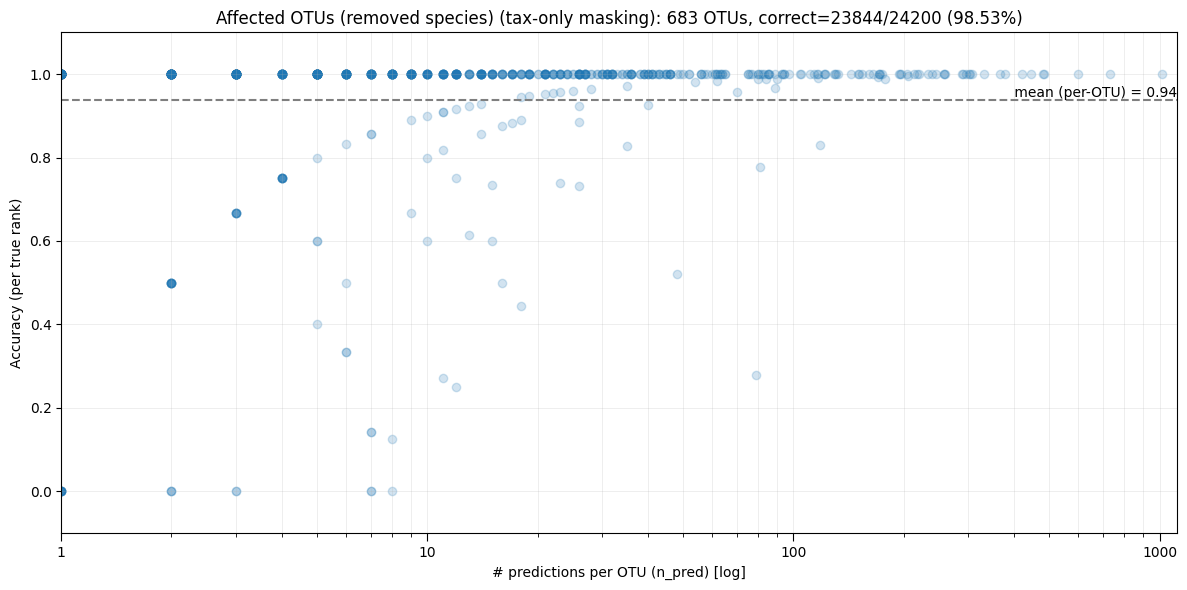

[INFO] multilabel eval: 10513 unique samples, 24200 predictions, 683 OTUs | correct=23844/24200 (98.53%)


In [10]:
df_rows, df_per_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    OUT_JSONL_AFFECTED,
    title_prefix="Affected OTUs (removed species) (tax-only masking)",
    make_plot=True,
    test_ids=None,
)


In [11]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Union, Tuple, Optional, Set, Dict, List

def plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path: Union[str, Path],
    ancestor_at_rank: Dict[str, List[int]],   # rank -> dense list len T_base with ancestor_id or -1
    test_ids: Optional[Set[str]] = None,
    ranks=("k","p","c","o","f","g","s"),
    level_labels=None,
    otu_col: str = "otu_name",
    title: str = "Hierarchical model: per-level accuracy",
    make_plot: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, dict, Optional[plt.Figure]]:
    """
    Per-level accuracy for hierarchical predictions.

    For each row and each rank r:
      gold_r = ancestor_at_rank[r][true_tax_id]  (or -1 if missing)
      pred_r = pred_by_rank[r]["tax_id"]
      Compare pred_r vs gold_r only when gold_r != -1

    Returns:
      df (row-level), summary_df (rank-level), overall dict, fig
    """
    jsonl_path = Path(jsonl_path)
    df = pd.read_json(str(jsonl_path), lines=True)

    if level_labels is None:
        level_labels = {"k":"kingdom","p":"phylum","c":"class",
                        "o":"order","f":"family","g":"genus","s":"species"}

    # optional strict filtering
    if test_ids is not None and "sample_id" in df.columns:
        test_ids = set(map(str, test_ids))
        df["sample_id"] = df["sample_id"].astype(str)
        df = df[df["sample_id"].isin(test_ids)].copy()

    if df.empty:
        print("[WARN] No rows to evaluate after loading/filtering.")
        return df, pd.DataFrame(), {
            "n_samples": 0,
            "n_rows": 0,
            "micro_overall": float("nan"),
            "mean_macro_overall": float("nan"),
        }, None

    # ensure true_tax_id is int
    df["true_tax_id"] = df["true_tax_id"].astype(int)

    # extract pred_{r} columns from pred_by_rank
    for r in ranks:
        pred_col = f"pred_{r}"
        if pred_col not in df.columns:
            def _get_pred(d):
                if not isinstance(d, dict):
                    return None
                x = d.get(r, None)
                if not isinstance(x, dict):
                    return None
                try:
                    return int(x.get("tax_id"))
                except Exception:
                    return None
            df[pred_col] = df["pred_by_rank"].apply(_get_pred) if "pred_by_rank" in df.columns else None

    # gold_{r} from dense ancestor arrays
    for r in ranks:
        gold_col = f"gold_{r}"
        arr = ancestor_at_rank[r]
        df[gold_col] = df["true_tax_id"].apply(lambda t: arr[t] if (0 <= t < len(arr)) else -1)

    # compute micro & macro per rank
    def _metrics_at_rank(df_local: pd.DataFrame, r: str):
        pred_col = f"pred_{r}"
        gold_col = f"gold_{r}"

        # only rows where gold exists
        sub = df_local[df_local[gold_col] != -1].copy()
        if len(sub) == 0:
            return np.nan, np.nan, 0, 0

        pred_vals = sub[pred_col].fillna(-1).astype("int64").to_numpy()
        gold_vals = sub[gold_col].astype("int64").to_numpy()
        corr = (pred_vals == gold_vals)
        micro = float(corr.mean())

        # macro over OTUs
        def _per_otu_acc(s):
            idx = s.index
            s_pred = s.fillna(-1).astype("int64").to_numpy()
            s_gold = sub.loc[idx, gold_col].astype("int64").to_numpy()
            return float((s_pred == s_gold).mean())

        macro = float(sub.groupby(otu_col)[pred_col].apply(_per_otu_acc).mean())
        n_otus = int(sub[otu_col].nunique())
        n_rows = int(len(sub))
        return micro, macro, n_otus, n_rows

    micro_arr, macro_arr, otus_used, rows_used = [], [], [], []
    for r in ranks:
        m, M, n_otus, n_rows = _metrics_at_rank(df, r)
        micro_arr.append(m)
        macro_arr.append(M)
        otus_used.append(n_otus)
        rows_used.append(n_rows)

    overall = {
        "n_samples": int(df["sample_id"].nunique()) if "sample_id" in df.columns else None,
        "n_rows": int(len(df)),
        "micro_overall": float(np.nanmean(micro_arr)),
        "mean_macro_overall": float(np.nanmean(macro_arr)),
    }

    fig = None
    if make_plot:
        x = [level_labels[r] for r in ranks]
        fig, ax1 = plt.subplots(figsize=(9.5, 5))

        ax1.plot(x, micro_arr, marker="o", linewidth=2, label="Micro accuracy")
        ax1.plot(x, macro_arr, marker=".", linestyle="--", linewidth=2, label="Macro accuracy")

        for xi, yi in zip(x, macro_arr):
            if np.isfinite(yi):
                ax1.text(xi, yi + 0.03, f"{yi:.3f}", ha="center", va="bottom", fontsize=9)

        ax1.set_ylim(0.0, 1.02)
        ax1.set_ylabel("Accuracy")
        ax1.set_xlabel("Taxonomic level")
        ax1.set_title(title)
        ax1.grid(True, axis="y", alpha=0.3)

        ax2 = ax1.twinx()
        ax2.bar(x, otus_used, alpha=0.25, label="# OTUs")
        ax2.set_ylabel("Number of OTUs")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

        plt.tight_layout()
        plt.show()

    summary_df = pd.DataFrame({
        "level": [level_labels[r] for r in ranks],
        "n_rows_used": rows_used,
        "n_otus_used": otus_used,
        "micro_acc": [round(v,4) if np.isfinite(v) else None for v in micro_arr],
        "macro_acc": [round(v,4) if np.isfinite(v) else None for v in macro_arr],
    })

    print(
        "[INFO] overall micro (avg over levels) = {:.3f}, mean macro (avg over levels) = {:.3f}".format(
            overall["micro_overall"], overall["mean_macro_overall"]
        )
    )

    return df, summary_df, overall, fig


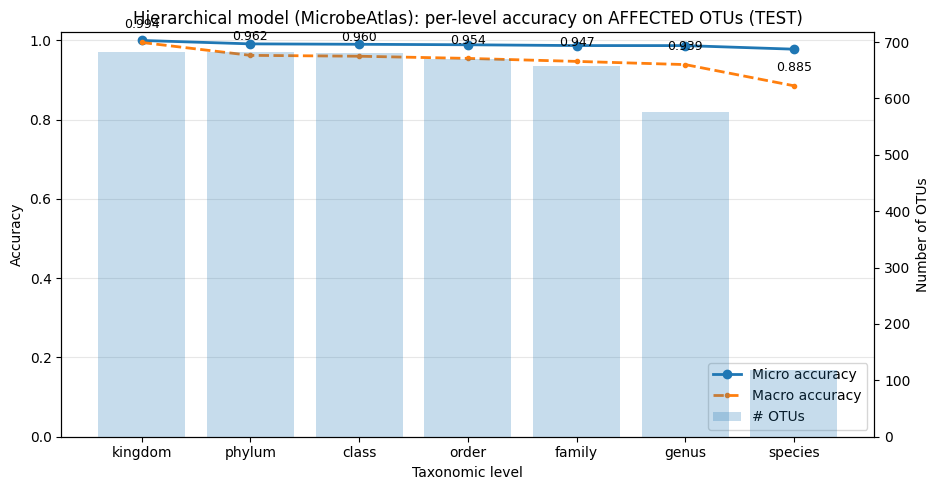

[INFO] overall micro (avg over levels) = 0.989, mean macro (avg over levels) = 0.949


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,24200,683,0.9995,0.9945
1,phylum,24158,682,0.9909,0.9619
2,class,24156,680,0.9899,0.9597
3,order,24027,670,0.9886,0.9543
4,family,23664,657,0.9866,0.9467
5,genus,22407,576,0.9865,0.9387
6,species,3112,119,0.9775,0.8852


In [13]:
JSONL_PER_RANK = OUT_JSONL_AFFECTED  # <-- change from OUT_JSONL_RANDOM

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (MicrobeAtlas): per-level accuracy on AFFECTED OTUs (TEST)"
)

display(per_level_summary)

In [14]:
from matplotlib.gridspec import GridSpec


RANKS = ("k","p","c","o","f","g","s")


# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank


# ------------------------------------------------------------
# 1) Load predictions + add pred_{r} + gold_{r}
# ------------------------------------------------------------
def load_predictions_with_pred_gold(
    jsonl_path,
    ancestor_at_rank,
    ranks=RANKS,
):
    df = pd.read_json(str(Path(jsonl_path)), lines=True)
    if df.empty:
        raise ValueError("Empty predictions file.")

    # ensure ints where needed
    df["true_tax_id"] = df["true_tax_id"].astype(int)

    # pred_{r} from pred_by_rank
    for r in ranks:
        pred_col = f"pred_{r}"
        if pred_col not in df.columns:
            def _get_pred(d):
                if not isinstance(d, dict):
                    return None
                x = d.get(r, None)
                if not isinstance(x, dict):
                    return None
                try:
                    return int(x.get("tax_id"))
                except Exception:
                    return None
            df[pred_col] = df["pred_by_rank"].apply(_get_pred) if "pred_by_rank" in df.columns else None

    # gold_{r} from dense arrays
    for r in ranks:
        gold_col = f"gold_{r}"
        arr = ancestor_at_rank[r]
        df[gold_col] = df["true_tax_id"].apply(lambda t: arr[t] if 0 <= t < len(arr) else -1)

    return df


# ------------------------------------------------------------
# 2) Correctness flags + deepest-rank + rankACC
# ------------------------------------------------------------
def _ensure_ok_columns(df, ranks=RANKS):
    """
    ok_{r} in {1.0, 0.0, NaN}:
      - NaN if gold_r missing (gold_r == -1)
      - 1.0 if pred_r == gold_r
      - 0.0 otherwise
    """
    df = df.copy()
    for r in ranks:
        pred = df[f"pred_{r}"]
        gold = df[f"gold_{r}"]

        has = (gold != -1)
        ok = pd.Series(np.nan, index=df.index, dtype="float")
        ok.loc[has] = (
            pred.loc[has].fillna(-1).astype("int64").to_numpy()
            ==
            gold.loc[has].fillna(-1).astype("int64").to_numpy()
        ).astype(float)

        df[f"ok_{r}"] = ok
    return df


def _deepest_gold_rank(row, ranks=RANKS):
    for r in reversed(ranks):
        if row.get(f"gold_{r}", -1) != -1:
            return r
    return None


def _first_wrong_rank_up_to_target(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        if row[f"gold_{r}"] == -1:
            continue
        ok = row[f"ok_{r}"]  # 1.0/0.0/NaN
        if (not pd.isna(ok)) and (ok < 0.5):
            return r
    return None  # fully correct up to target


def _rankACC_for_row(row, target_rank, ranks=RANKS):
    """
    rankACC = m/D where D = index(target)+1, m = # consecutive correct from root until first error.
    Missing gold within k..target is skipped safely.
    """
    D = ranks.index(target_rank) + 1
    m = 0
    for r in ranks[:D]:
        if row[f"gold_{r}"] == -1:
            continue
        ok = row[f"ok_{r}"]
        if pd.isna(ok):
            continue
        if ok >= 0.5:
            m += 1
        else:
            break
    return float(m / max(1, D))


# ------------------------------------------------------------
# 3) Strict matrix + per-rank mean rankACC 
# ------------------------------------------------------------
def strict_error_origin_matrix_and_rankACC(df, ranks=RANKS):
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()

    # deepest rank per row
    df2["deepest_rank"] = df2.apply(lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    counts = pd.DataFrame(0, index=ranks, columns=ranks, dtype=int)
    meta_rows = []

    for target in ranks:
        sub = df2[df2["deepest_rank"] == target].copy()
        n_preds = int(len(sub))

        if n_preds == 0:
            meta_rows.append({
                "rank": target,
                "n_preds_strict": 0,
                "n_errors_strict": 0,
                "strict_error_rate": np.nan,
                "rankACC_mean": np.nan,
            })
            continue

        # rankACC per row
        sub["rankACC"] = sub.apply(lambda row: _rankACC_for_row(row, target, ranks=ranks), axis=1)
        rankACC_mean = float(sub["rankACC"].mean())

        # errors are rows not fully correct up to target
        err_mask = sub["rankACC"] < 0.999999
        errs = sub[err_mask].copy()
        n_errors = int(len(errs))

        if n_errors > 0:
            errs["first_wrong"] = errs.apply(
                lambda row: _first_wrong_rank_up_to_target(row, target, ranks=ranks),
                axis=1
            )
            vc = errs["first_wrong"].value_counts(dropna=True)
            for col_rank, cnt in vc.items():
                counts.loc[target, col_rank] = int(cnt)

        meta_rows.append({
            "rank": target,
            "n_preds_strict": n_preds,
            "n_errors_strict": n_errors,
            "strict_error_rate": float(n_errors / max(1, n_preds)),
            "rankACC_mean": rankACC_mean,
        })

    meta = pd.DataFrame(meta_rows).set_index("rank")
    return counts, meta


# ------------------------------------------------------------
# 4) Plot 
# ------------------------------------------------------------
def plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent: bool = True,
):
    ranks = list(ranks)

    mat = counts_strict.loc[ranks, ranks].fillna(0).astype(int)
    n_preds = meta_strict.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()
    rankacc = meta_strict.loc[ranks, "rankACC_mean"].to_numpy()
    rankacc = np.nan_to_num(rankacc, nan=0.0)

    extra = ""
    if df is not None:
        if otu_col in df.columns:
            n_otus = int(df[otu_col].nunique())
        elif "otu_name" in df.columns:
            n_otus = int(df["otu_name"].nunique())
        else:
            n_otus = None
        n_predictions = int(len(df))
        extra = f"OTUs={n_otus} | N predictions={n_predictions}" if n_otus is not None else f"N predictions={n_predictions}"

    fig = plt.figure(figsize=(10.6, 6.8))
    gs = GridSpec(
        2, 3,
        height_ratios=[0.75, 6.0],
        width_ratios=[20, 3.2, 1.1],
        hspace=0.06,
        wspace=0.10
    )

    # -------------------------
    # Top denominators (# predictions per deepest rank)
    # -------------------------
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# predictions")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds.max()) if len(n_preds) else 1)
    ax_top.set_ylim(0, ymax * 1.12)
    for i, n in enumerate(n_preds):
        ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # -------------------------
    # Heatmap (error-origin counts)
    # -------------------------
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)
    data = mat.to_numpy()
    im = ax_hm.imshow(data, aspect="auto", cmap="Blues")

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks(range(len(ranks)))
    ax_hm.set_yticklabels(ranks)

    # Axis names (no "strict")
    ax_hm.set_xlabel("First incorrect rank")
    ax_hm.set_ylabel("Deepest available label")

    vmax = int(data.max()) if data.size else 1

    # Row-wise percent: share of predictions at the same deepest rank (row)
    def _row_pct(i_row: int, v: int) -> float:
        denom_row = int(n_preds[i_row]) if i_row < len(n_preds) else 0
        if v <= 0 or denom_row <= 0:
            return 0.0
        return 100.0 * (v / denom_row)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            v = int(data[i, j])
            is_lower = (j <= i)

            if v > 0:
                if show_percent:
                    pct = _row_pct(i, v)
                    txt = f"{v}\n({pct:.2f}%)"
                else:
                    txt = f"{v}"

                ax_hm.text(
                    j, i, txt,
                    ha="center", va="center",
                    fontsize=8,
                    color="white" if v > 0.6 * vmax else "black",
                    linespacing=0.9,
                )
            elif show_zeros_lower and is_lower:
                ax_hm.text(j, i, "0", ha="center", va="center", fontsize=7, color="0.65")

    # -------------------------
    # rankACC bars
    # -------------------------
    ax_ra = fig.add_subplot(gs[1, 1], sharey=ax_hm)
    y = np.arange(len(ranks))
    ax_ra.barh(y, rankacc, color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_xlabel("rankACC")
    ax_ra.tick_params(axis="y", left=False, labelleft=False)

    for i, v in enumerate(rankacc):
        ax_ra.text(0.04, i, f"{v*100:.1f}%", va="center", ha="left", fontsize=9, color="black")

    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # -------------------------
    # Colorbar
    # -------------------------
    ax_cb = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Number of errors")

    # Subtitle clarifies denominator for % values
    subtitle = extra
    if show_percent:
        if subtitle:
            subtitle = subtitle 
        #subtitle = subtitle + "cell % = share within the row (same depth)"

    fig.suptitle(f"{title}\n{subtitle}", y=0.985, fontsize=13, linespacing=1.3)
    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


# ------------------------------------------------------------
# 5) Global rankACC (one scalar)
# ------------------------------------------------------------
def compute_global_rankACC(df, ranks=RANKS):
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()
    df2["deepest_rank"] = df2.apply(lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    df2["rankACC"] = df2.apply(lambda row: _rankACC_for_row(row, row["deepest_rank"], ranks=ranks), axis=1)
    return float(df2["rankACC"].mean()), df2


Global rankACC: 0.9901


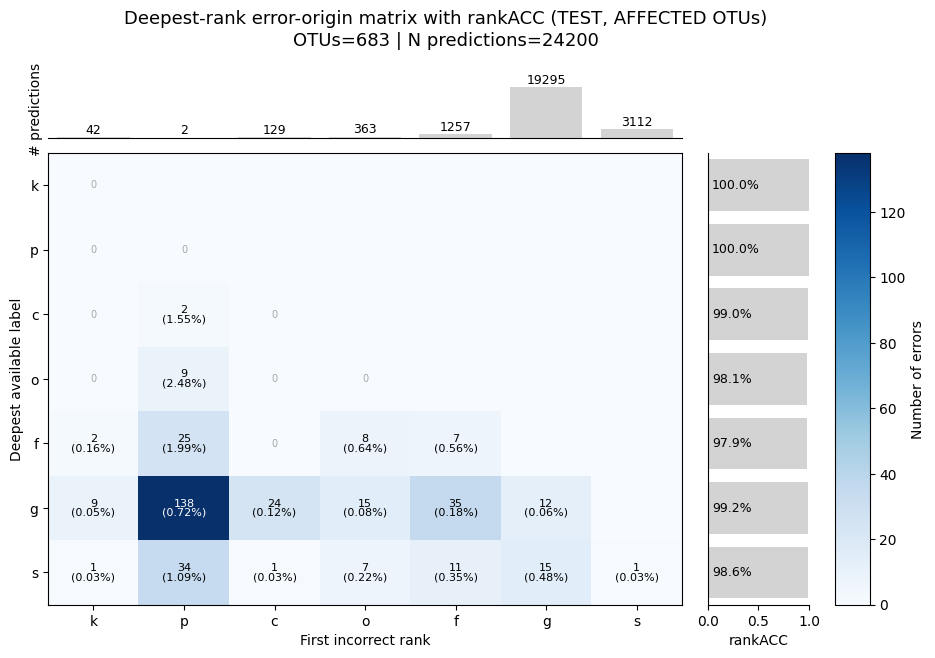

In [15]:

# 1) Build ancestor arrays from UNK artifacts 
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)

# 2) Load predictions from the AFFECTED jsonl
df = load_predictions_with_pred_gold(
    jsonl_path=OUT_JSONL_AFFECTED,     
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)

# 3) Strict matrix + meta for plot
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# 4) Plot 
plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title="Deepest-rank error-origin matrix with rankACC (TEST, AFFECTED OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
)

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")

In [107]:
def plot_error_origin_matrix_rowpct_colored(
    counts,
    meta,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text: bool = True,     # annotate each cell with (row %)
    vmax_pct: float = 5.0,              # fixed scale upper bound in percentage points
    vmin_pct: float = 0.0,              # fixed scale lower bound
):
    ranks = list(ranks)

    # counts: errors per (deepest_rank=row, first_wrong=col)
    mat_counts = counts.loc[ranks, ranks].fillna(0).astype(int)
    data_counts = mat_counts.to_numpy()

    # denominators for row %: number of predictions whose deepest rank is that row
    n_preds = meta.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()

    # rankACC panel
    rankacc = meta.loc[ranks, "rankACC_mean"].to_numpy()
    rankacc = np.nan_to_num(rankacc, nan=0.0)

    # extra info line
    extra = ""
    if df is not None:
        if otu_col in df.columns:
            n_otus = int(df[otu_col].nunique())
        elif "otu_name" in df.columns:
            n_otus = int(df["otu_name"].nunique())
        else:
            n_otus = None
        n_predictions = int(len(df))
        extra = f"OTUs={n_otus} | N predictions={n_predictions}" if n_otus is not None else f"N predictions={n_predictions}"

    # -------------------------------------------------
    # Build the COLOR matrix: row-normalized percentage
    # pct[i,j] = 100 * count[i,j] / n_preds[i]
    # -------------------------------------------------
    data_pct = np.zeros_like(data_counts, dtype=float)
    for i in range(data_counts.shape[0]):
        denom = float(n_preds[i])
        if denom > 0:
            data_pct[i, :] = 100.0 * (data_counts[i, :] / denom)
        else:
            data_pct[i, :] = 0.0

    fig = plt.figure(figsize=(10.6, 6.8))
    gs = GridSpec(
        2, 3,
        height_ratios=[0.75, 6.0],
        width_ratios=[20, 3.2, 1.1],
        hspace=0.06,
        wspace=0.10
    )

    # -------------------------
    # Top denominators
    # -------------------------
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# predictions")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds.max()) if len(n_preds) else 1)
    ax_top.set_ylim(0, ymax * 1.12)
    for i, n in enumerate(n_preds):
        ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # -------------------------
    # Heatmap colored by ROW %
    # -------------------------
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)

    im = ax_hm.imshow(
        data_pct,
        aspect="auto",
        cmap="Blues",
        vmin=vmin_pct,
        vmax=vmax_pct,
    )

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks(range(len(ranks)))
    ax_hm.set_yticklabels(ranks)

    ax_hm.set_xlabel("First incorrect prediction")
    ax_hm.set_ylabel("Deepest available label")

    # annotate: show counts and optionally row %
    for i in range(data_counts.shape[0]):
        for j in range(data_counts.shape[1]):
            v = int(data_counts[i, j])
            is_lower = (j <= i)

            if v > 0:
                pct = float(data_pct[i, j])
                if show_percent_text:
                    txt = f"{v}\n({pct:.2f}%)"
                else:
                    txt = f"{v}"

                # choose text color based on pct scale (not counts)
                txt_color = "white" if pct > 0.6 * vmax_pct else "black"

                ax_hm.text(
                    j, i, txt,
                    ha="center", va="center",
                    fontsize=8,
                    color=txt_color,
                    linespacing=0.9,
                )
            elif show_zeros_lower and is_lower:
                ax_hm.text(j, i, "0", ha="center", va="center", fontsize=7, color="0.65")

    # -------------------------
    # rankACC bars
    # -------------------------
    ax_ra = fig.add_subplot(gs[1, 1], sharey=ax_hm)
    y = np.arange(len(ranks))
    ax_ra.barh(y, rankacc, color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_xlabel("rankACC")
    ax_ra.tick_params(axis="y", left=False, labelleft=False)
    for i, v in enumerate(rankacc):
        ax_ra.text(0.04, i, f"{v*100:.1f}%", va="center", ha="left", fontsize=9, color="black")
    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # -------------------------
    # Colorbar (now in %)
    # -------------------------
    ax_cb = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Error rate per row (%)")

    # Title
    #fig.suptitle(f"{title}\n{extra}", y=0.985, fontsize=13, linespacing=1.3)

    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


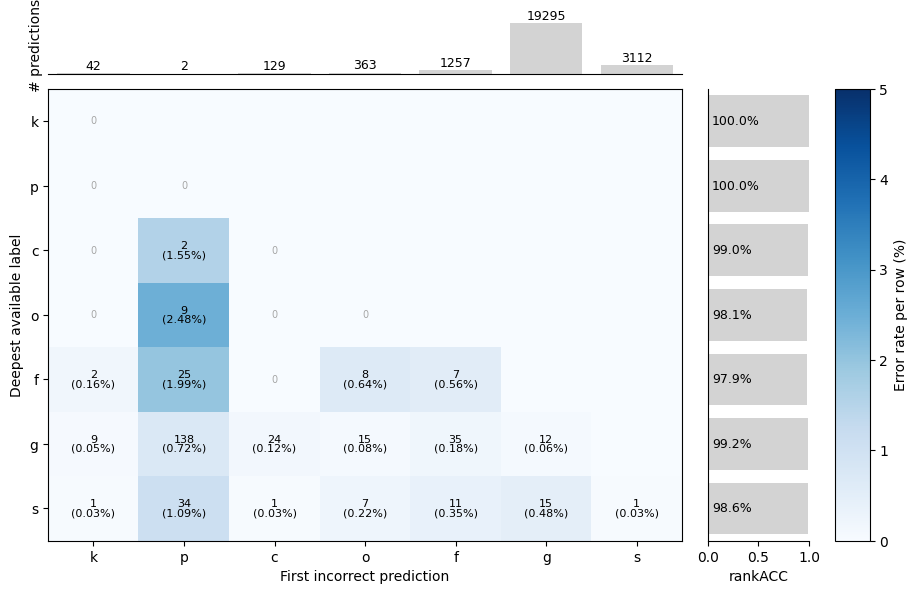

In [108]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Error-origin matrix with rankACC (TEST, affected OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  # keep the per-cell row %
    vmax_pct=5.0,            # fixed 0–5% scale for comparability
    vmin_pct=0.0,
)


# table rankACC vs ACC

In [33]:
import pandas as pd
import numpy as np

RANKS = ("k","p","c","o","f","g","s")

def build_accuracy_vs_rankACC_table(df, ranks=RANKS):
    """
    Returns a DataFrame with:
      rows  : k, p, c, o, f, g, s, Global
      cols  : standard_accuracy, rankACC
    """

    # --------------------------------------------------
    # Ensure required columns exist
    # --------------------------------------------------
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()

    if "deepest_rank" not in df2.columns:
        df2["deepest_rank"] = df2.apply(
            lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1
        )

    # --------------------------------------------------
    # Per-rank metrics
    # --------------------------------------------------
    rows = []

    for r in ranks:
        # rows whose deepest available label is r
        sub = df2[df2["deepest_rank"] == r]

        if len(sub) == 0:
            rows.append({
                "rank": r,
                "standard_accuracy": np.nan,
                "rankACC": np.nan,
                "n_rows": 0,
            })
            continue

        # ---- standard accuracy at rank r (micro) ----
        ok_col = f"ok_{r}"
        valid = sub[ok_col].notna()

        if valid.any():
            standard_acc = float(sub.loc[valid, ok_col].mean())
        else:
            standard_acc = np.nan

        # ---- rankACC (same definition as your strict metric) ----
        sub_rankacc = sub.apply(
            lambda row: _rankACC_for_row(row, r, ranks=ranks), axis=1
        )
        rankacc_mean = float(sub_rankacc.mean())

        rows.append({
            "rank": r,
            "standard_accuracy": standard_acc,
            "rankACC": rankacc_mean,
            "n_rows": int(len(sub)),
        })

    per_rank_df = pd.DataFrame(rows).set_index("rank")

    # --------------------------------------------------
    # Global metrics
    # --------------------------------------------------
    global_rankACC, df_with_rankacc = compute_global_rankACC(df2, ranks=ranks)

    # global standard accuracy = exact match at deepest rank
    def _deepest_ok(row):
        r = row["deepest_rank"]
        if r is None:
            return np.nan
        return row.get(f"ok_{r}", np.nan)

    global_standard_acc = float(
        df2.apply(_deepest_ok, axis=1).dropna().mean()
    )

    global_row = pd.DataFrame(
        [{
            "standard_accuracy": global_standard_acc,
            "rankACC": global_rankACC,
            "n_rows": int(len(df2)),
        }],
        index=["Global"]
    )

    # --------------------------------------------------
    # Final table
    # --------------------------------------------------
    table = pd.concat([per_rank_df, global_row], axis=0)

    return table


In [34]:
acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)

# nicer formatting
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,1.0000,1.0000,42
p,1.0000,1.0000,2
c,0.9845,0.9897,129
o,0.9752,0.9814,363
f,0.9666,0.9788,1257
g,0.9879,0.9916,19295
s,0.9775,0.9859,3112
Global,0.9853,0.9901,24200


# cheking error details 

In [94]:
RANKS = ("k","p","c","o","f","g","s")

# df is your dataframe after load_predictions_with_pred_gold(...)
# add ok columns (if not already present)
df2 = _ensure_ok_columns(df, ranks=RANKS).copy()

# deepest available label per row
df2["deepest_rank"] = df2.apply(lambda r: _deepest_gold_rank(r, ranks=RANKS), axis=1)

# first wrong rank up to target depth (same logic as the matrix)
df2["first_wrong"] = df2.apply(
    lambda r: _first_wrong_rank_up_to_target(r, r["deepest_rank"], ranks=RANKS)
    if r["deepest_rank"] is not None else None,
    axis=1
)

# ---- choose the slice you want to inspect ----
target_depth = "g"   # deepest labeled rank = genus
origin_rank  = "p"   # first incorrect rank = phylum

slice_df = df2[
    (df2["deepest_rank"] == target_depth) &
    (df2["first_wrong"] == origin_rank)
].copy()

print("Rows in slice:", len(slice_df))
print("Unique OTUs in slice:", slice_df["otu_id"].nunique() if "otu_id" in slice_df.columns else slice_df["otu_name"].nunique())


def tax_name(tid: int) -> str:
    if tid is None or int(tid) < 0:
        return "<missing>"
    return tax_id2name.get(int(tid), f"<id:{int(tid)}>")

for r in ["k","p","c","o","f","g"]:
    slice_df[f"gold_{r}_name"] = slice_df[f"gold_{r}"].apply(tax_name)
    slice_df[f"pred_{r}_name"] = slice_df[f"pred_{r}"].fillna(-1).astype(int).apply(tax_name)

# Keep a compact view
cols = [
    "sample_id","otu_id","otu_name","position",
    "gold_p_name","pred_p_name",
    "gold_g_name","pred_g_name",
    "gold_f_name","pred_f_name",
]
cols = [c for c in cols if c in slice_df.columns]
slice_df_view = slice_df[cols].copy()

slice_df_view.head(20)


Rows in slice: 138
Unique OTUs in slice: 31


,sample_id,otu_id,otu_name,position,gold_p_name,pred_p_name,gold_g_name,pred_g_name,gold_f_name,pred_f_name
62,SRR4266029.SRS1703876,18072,90_15360;96_12610;97_15304,462,p:Actinobacteria,p:Bacteroidetes,g:Tessaracoccus,g:UNK,f:Propionibacteriaceae,f:Chitinophagaceae
423,ERR1103190.ERS948915,6891,90_1051;96_17920;97_22094,171,p:Verrucomicrobia,p:Bacteroidetes,g:Rubritalea,g:UNK,f:Rubritaleaceae,f:Flavobacteriaceae
752,ERR1771484.ERS1488758,6891,90_1051;96_17920;97_22094,365,p:Verrucomicrobia,p:Bacteroidetes,g:Rubritalea,g:UNK,f:Rubritaleaceae,f:Flavobacteriaceae
1219,ERR1110349.ERS953884,4960,90_259;96_1030;97_1203,82,p:Proteobacteria,p:Bacteroidetes,g:Succinatimonas,g:Alistipes,f:Succinivibrionaceae,f:Rikenellaceae
1908,ERR1085876.ERS937595,48544,90_17518;96_10554;97_12758,65,p:Firmicutes,p:Bacteroidetes,g:Erysipelothrix,g:Myroides,f:Erysipelotrichaceae,f:Flavobacteriaceae
1918,ERR1085782.ERS937501,29239,90_1051;96_28478;97_35885,92,p:Verrucomicrobia,p:Bacteroidetes,g:Rubritalea,g:UNK,f:Rubritaleaceae,f:Flavobacteriaceae
1936,ERR1086145.ERS937864,48544,90_17518;96_10554;97_12758,172,p:Firmicutes,p:Bacteroidetes,g:Erysipelothrix,g:Myroides,f:Erysipelotrichaceae,f:Flavobacteriaceae
2476,ERR1293607.ERS1066661,4960,90_259;96_1030;97_1203,39,p:Proteobacteria,p:Bacteroidetes,g:Succinatimonas,g:Alistipes,f:Succinivibrionaceae,f:Rikenellaceae
2815,ERR441959.ERS412964,13850,90_15804;96_8606;97_24639,288,p:Synergistetes,p:Bacteroidetes,g:Fretibacterium,g:UNK,f:Synergistaceae,f:ML635J-40_aquatic_group
2925,SRR978403.SRS479641,6891,90_1051;96_17920;97_22094,23,p:Verrucomicrobia,p:Bacteroidetes,g:Rubritalea,g:UNK,f:Rubritaleaceae,f:Flavobacteriaceae


In [93]:
import pandas as pd

def add_sample_prefix_columns(df: pd.DataFrame, sample_col: str = "sample_id", ers_prefix_len: int = 5):
    """
    Adds:
      - run_id: 'ERR...' part (before '.')
      - sample_acc: 'ERS...' part (after '.')
      - ers_prefix: first `ers_prefix_len` chars of sample_acc (e.g., 'ERS93')
    """
    out = df.copy()
    s = out[sample_col].astype(str)

    # split on first dot
    parts = s.str.split(".", n=1, expand=True)
    out["run_id"] = parts[0]

    # ERS part may be missing for some rows
    out["sample_acc"] = parts[1] if parts.shape[1] > 1 else None

    # prefix (your "study proxy")
    out["ers_prefix"] = out["sample_acc"].fillna("").astype(str).str[:ers_prefix_len]
    out.loc[out["ers_prefix"] == "", "ers_prefix"] = pd.NA
    return out


def summarize_studies_by_prefix(df: pd.DataFrame, prefix_col: str = "ers_prefix", topk: int = 20):
    """
    Returns a table of counts per prefix + % of rows.
    """
    vc = df[prefix_col].value_counts(dropna=False).head(topk)
    out = vc.to_frame("n_rows")
    out["pct_rows"] = (100.0 * out["n_rows"] / len(df)).round(2)
    return out.reset_index().rename(columns={"index": prefix_col})


# ----------------------------
# Example: run on your slice_df or df2
# ----------------------------
# Choose which dataframe you want to analyze:
# df_use = slice_df_view   # if it contains sample_id
df_use = slice_df          # recommended (has all rows)

df_use2 = add_sample_prefix_columns(df_use, sample_col="sample_id", ers_prefix_len=5)

print("Rows:", len(df_use2))
print("Unique run_id:", df_use2["run_id"].nunique())
print("Unique sample_acc (ERS...):", df_use2["sample_acc"].nunique())

# Top "study proxies" (ERSxx prefixes)
tbl = summarize_studies_by_prefix(df_use2, prefix_col="ers_prefix", topk=20)
display(tbl)

# ----------------------------
# Filter to one prefix (e.g., 'ERS93')
# ----------------------------
target_prefix = "SRS31"
df_ers93 = df_use2[df_use2["ers_prefix"] == target_prefix].copy()

print(f"\n[{target_prefix}] rows:", len(df_ers93))
print(f"[{target_prefix}] unique OTUs:", df_ers93["otu_id"].nunique() if "otu_id" in df_ers93.columns else df_ers93["otu_name"].nunique())

display(df_ers93[["sample_id","run_id","sample_acc","ers_prefix","otu_id","otu_name"]].head(50))


Rows: 138
Unique run_id: 133
Unique sample_acc (ERS...): 133


,ers_prefix,n_rows,pct_rows
0,SRS31,17,12.32
1,SRS68,5,3.62
2,SRS39,4,2.90
3,SRS28,4,2.90
4,SRS38,4,2.90
5,SRS35,4,2.90
6,ERS45,3,2.17
7,ERS93,3,2.17
8,SRS65,3,2.17
9,ERS41,3,2.17



[SRS31] rows: 17
[SRS31] unique OTUs: 4


,sample_id,run_id,sample_acc,ers_prefix,otu_id,otu_name
9589,SRR6975554.SRS3152360,SRR6975554,SRS3152360,SRS31,4960,90_259;96_1030;97_1203
9592,SRR6975389.SRS3152519,SRR6975389,SRS3152519,SRS31,4960,90_259;96_1030;97_1203
9606,SRR6975646.SRS3152267,SRR6975646,SRS3152267,SRS31,4960,90_259;96_1030;97_1203
9611,SRR6975315.SRS3152596,SRR6975315,SRS3152596,SRS31,4960,90_259;96_1030;97_1203
9896,SRR7035501.SRS3195021,SRR7035501,SRS3195021,SRS31,6891,90_1051;96_17920;97_22094
9904,SRR7034811.SRS3194547,SRR7034811,SRS3194547,SRS31,54274,90_50;96_3005;97_3692
9916,SRR7036714.SRS3195579,SRR7036714,SRS3195579,SRS31,6891,90_1051;96_17920;97_22094
10492,SRR7596398.SRS3194904,SRR7596398,SRS3194904,SRS31,6891,90_1051;96_17920;97_22094
10494,SRR7595804.SRS3195427,SRR7595804,SRS3195427,SRS31,6891,90_1051;96_17920;97_22094
10512,SRR7595290.SRS3195084,SRR7595290,SRS3195084,SRS31,6891,90_1051;96_17920;97_22094


In [86]:
# number of rows (sanity check)
print("Rows:", len(slice_df))

# count unique OTUs
if "otu_id" in slice_df.columns:
    n_unique_otus = slice_df["otu_id"].nunique()
    print("Unique OTUs (otu_id):", n_unique_otus)
else:
    n_unique_otus = slice_df["otu_name"].nunique()
    print("Unique OTUs (otu_name):", n_unique_otus)


Rows: 138
Unique OTUs (otu_id): 31


          gold_p_name     pred_p_name  count
    p:Verrucomicrobia p:Bacteroidetes     65
     p:Proteobacteria p:Bacteroidetes     24
     p:Actinobacteria p:Bacteroidetes     11
        p:Tenericutes p:Bacteroidetes     11
      p:Synergistetes p:Bacteroidetes      6
        p:Caldiserica p:Bacteroidetes      3
         p:Firmicutes p:Bacteroidetes      3
       p:Spirochaetae p:Bacteroidetes      3
        p:Thermotogae p:Bacteroidetes      3
      p:Cyanobacteria p:Bacteroidetes      2
     p:Planctomycetes p:Bacteroidetes      2
          p:Aquificae p:Bacteroidetes      1
           p:Chlorobi p:Bacteroidetes      1
p:Deinococcus-Thermus p:Bacteroidetes      1
     p:Proteobacteria    p:Firmicutes      1


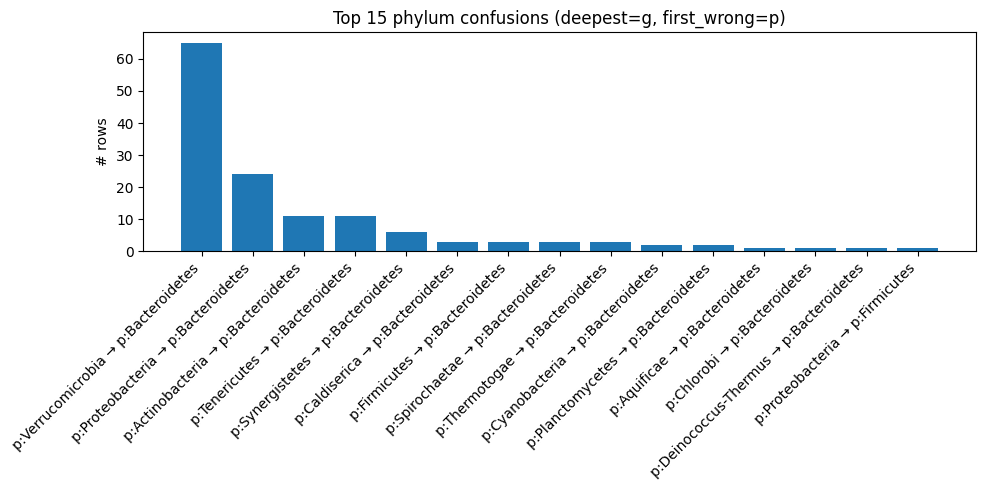

In [22]:
phylum_conf = (
    slice_df.groupby(["gold_p_name","pred_p_name"])
            .size()
            .reset_index(name="count")
            .sort_values("count", ascending=False)
)

print(phylum_conf.head(15).to_string(index=False))
topK = 15
top = phylum_conf.head(topK)

plt.figure(figsize=(10, 5))
plt.bar(range(len(top)), top["count"])
plt.xticks(
    range(len(top)),
    [f"{g} → {p}" for g,p in zip(top["gold_p_name"], top["pred_p_name"])],
    rotation=45, ha="right"
)
plt.ylabel("# rows")
plt.title(f"Top {topK} phylum confusions (deepest={target_depth}, first_wrong={origin_rank})")
plt.tight_layout()
plt.show()


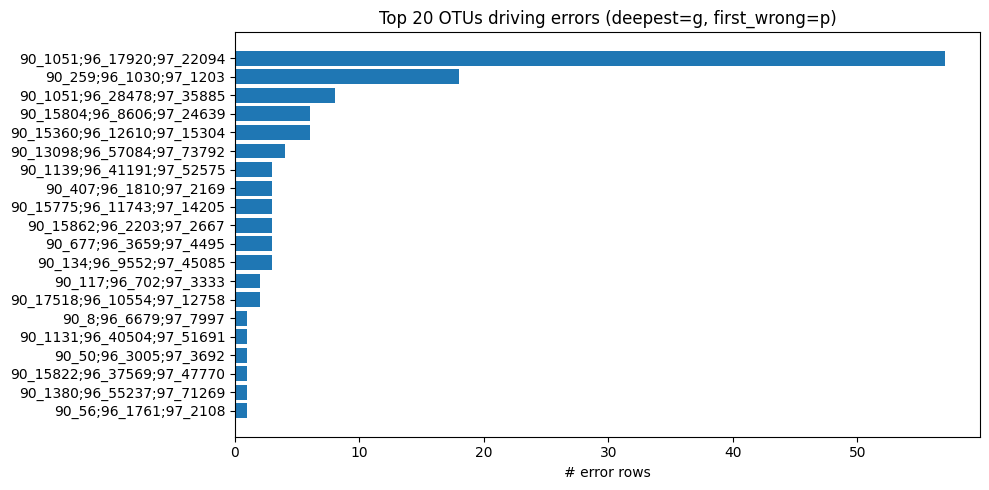

In [23]:
otu_key = "otu_id" if "otu_id" in slice_df.columns else "otu_name"

otu_counts = (
    slice_df.groupby(otu_key)
            .size()
            .reset_index(name="n_rows")
            .sort_values("n_rows", ascending=False)
)

# attach a name if available
if otu_key == "otu_id" and "otu_name" in slice_df.columns:
    otu_name_map = slice_df.drop_duplicates("otu_id")[["otu_id","otu_name"]].set_index("otu_id")["otu_name"]
    otu_counts["otu_name"] = otu_counts["otu_id"].map(otu_name_map)

otu_counts.head(20)
topN = 20
top_otus = otu_counts.head(topN)

plt.figure(figsize=(10, 5))
plt.barh(range(len(top_otus)), top_otus["n_rows"][::-1])
labels = (top_otus["otu_name"] if "otu_name" in top_otus.columns else top_otus[otu_key]).astype(str)
plt.yticks(range(len(top_otus)), labels[::-1])
plt.xlabel("# error rows")
plt.title(f"Top {topN} OTUs driving errors (deepest={target_depth}, first_wrong={origin_rank})")
plt.tight_layout()
plt.show()


# cheking collator distribution

In [25]:
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

RANK_P_IDX = 1  # k=0, p=1, c=2, ...

def _short_tax_name(name: str) -> str:
    # Keep just the label text; vocab typically has "p:Something"
    if not isinstance(name, str):
        return str(name)
    return name.split(":", 1)[1] if ":" in name else name

def sample_masked_phylum_distributions(
    *,
    dataset_subset,          # e.g. test_ds (Subset)
    collate_fn,              # your make_tax_only_mask_collator(..., T_base=..., max_len=...)
    model,
    device: str,
    T_base: int,
    ancestor_at_rank_p,      # dense list/np array length T_base: gold phylum id for each tax_id
    tax_id2name,             # dict[int->str] for UNK vocab (size T_base)
    M_dev,
    rank_idx_dev,
    hierarchical_predict_full_path,
    n_batches: int = 20,
    batch_size: int = 4,
    seed: int = 123,
    top_k: int = 25,
):
    """
    Samples a few batches and computes histograms over phylum:
      - gold phylum at masked positions (derived via ancestor_at_rank_p[true_tax_id])
      - predicted phylum at masked positions (decoded path; take phylum node)
      - wrong phylum cases (pred != gold), and the gold phylum distribution among those wrongs
    """

    random.seed(seed)
    idxs = list(range(len(dataset_subset)))
    random.shuffle(idxs)

    gold_phylum = Counter()
    pred_phylum = Counter()
    wrong_pred_phylum = Counter()
    wrong_gold_phylum = Counter()

    total_masked = 0
    total_wrong = 0

    model.eval()
    with torch.no_grad():
        for b in range(n_batches):
            batch_idx = idxs[b*batch_size:(b+1)*batch_size]
            if not batch_idx:
                break

            records = [dataset_subset[i] for i in batch_idx]
            batch = collate_fn(records)

            input_otus = batch["input_otus"].to(device)
            input_taxa = batch["input_taxa"].to(device)
            attn = batch["attention_mask"].to(device)

            out = model(input_otus=input_otus, input_taxa=input_taxa, attention_mask=attn)

            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model output missing taxonomy logits.")

            # loop masked positions
            B, L = input_otus.shape
            for bi in range(B):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    total_masked += 1

                    # ---- GOLD phylum from true_tax_id -> ancestor_at_rank_p ----
                    true_tid = true_seq[pos]
                    true_tid = int(true_tid.item() if torch.is_tensor(true_tid) else true_tid)

                    if not (0 <= true_tid < T_base):
                        continue  # skip specials just in case

                    gold_pid = int(ancestor_at_rank_p[true_tid])
                    if gold_pid < 0:
                        continue

                    gold_name = _short_tax_name(tax_id2name.get(gold_pid, f"<id:{gold_pid}>"))
                    gold_phylum[gold_name] += 1

                    # ---- PRED phylum from decoded path ----
                    logits_base = logits_tax[bi, pos, :T_base]  # [T_base]
                    path = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )
                    pred_pid = path.get(RANK_P_IDX, None)
                    if pred_pid is None:
                        continue

                    pred_pid = int(pred_pid)
                    pred_name = _short_tax_name(tax_id2name.get(pred_pid, f"<id:{pred_pid}>"))
                    pred_phylum[pred_name] += 1

                    # ---- wrong? ----
                    if pred_pid != gold_pid:
                        total_wrong += 1
                        wrong_pred_phylum[pred_name] += 1
                        wrong_gold_phylum[gold_name] += 1

    # -----------------------------
    # Print quick diagnostics
    # -----------------------------
    print(f"[SAMPLE] masked positions analyzed: {total_masked}")
    print(f"[SAMPLE] wrong phylum predictions: {total_wrong} ({(total_wrong/max(1,total_masked)):.2%})")

    def _print_top(counter, name, k=15):
        print(f"\nTop {k} {name}:")
        for ph, cnt in counter.most_common(k):
            print(f"  {ph:35s} {cnt:8d}  ({cnt/max(1,sum(counter.values())):.2%})")

    _print_top(gold_phylum, "GOLD phyla among masked positions", k=15)
    _print_top(pred_phylum, "PRED phyla among masked positions", k=15)
    _print_top(wrong_pred_phylum, "PRED phyla among WRONG cases", k=15)
    _print_top(wrong_gold_phylum, "GOLD phyla among WRONG cases", k=15)

    # -----------------------------
    # Plot: gold vs pred distributions (top_k)
    # -----------------------------
    def _plot_counter(counter, title, top_k=25):
        items = counter.most_common(top_k)
        labels = [x[0] for x in items][::-1]
        vals = [x[1] for x in items][::-1]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(vals)), vals)
        plt.yticks(range(len(vals)), labels)
        plt.xlabel("# masked positions")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    _plot_counter(gold_phylum, f"Gold phylum distribution at masked positions (sampled batches)", top_k=top_k)
    _plot_counter(pred_phylum, f"Predicted phylum distribution at masked positions (sampled batches)", top_k=top_k)
    _plot_counter(wrong_gold_phylum, f"Gold phyla among phylum-wrong cases (sampled batches)", top_k=min(top_k, 30))
    _plot_counter(wrong_pred_phylum, f"Predicted phyla among phylum-wrong cases (sampled batches)", top_k=min(top_k, 30))

    return {
        "gold_phylum": gold_phylum,
        "pred_phylum": pred_phylum,
        "wrong_gold_phylum": wrong_gold_phylum,
        "wrong_pred_phylum": wrong_pred_phylum,
        "total_masked": total_masked,
        "total_wrong": total_wrong,
    }


[SAMPLE] masked positions analyzed: 1616
[SAMPLE] wrong phylum predictions: 18 (1.11%)

Top 15 GOLD phyla among masked positions:
  Firmicutes                               649  (40.19%)
  Proteobacteria                           427  (26.44%)
  Actinobacteria                           210  (13.00%)
  Bacteroidetes                            181  (11.21%)
  Tenericutes                               35  (2.17%)
  Cyanobacteria                             20  (1.24%)
  Fusobacteria                              17  (1.05%)
  Verrucomicrobia                           16  (0.99%)
  Acetothermia                              13  (0.80%)
  Planctomycetes                            10  (0.62%)
  Spirochaetae                               8  (0.50%)
  Chloroflexi                                6  (0.37%)
  Gemmatimonadetes                           6  (0.37%)
  Euryarchaeota                              5  (0.31%)
  Lentisphaerae                              3  (0.19%)

Top 15 PRED phyla among m

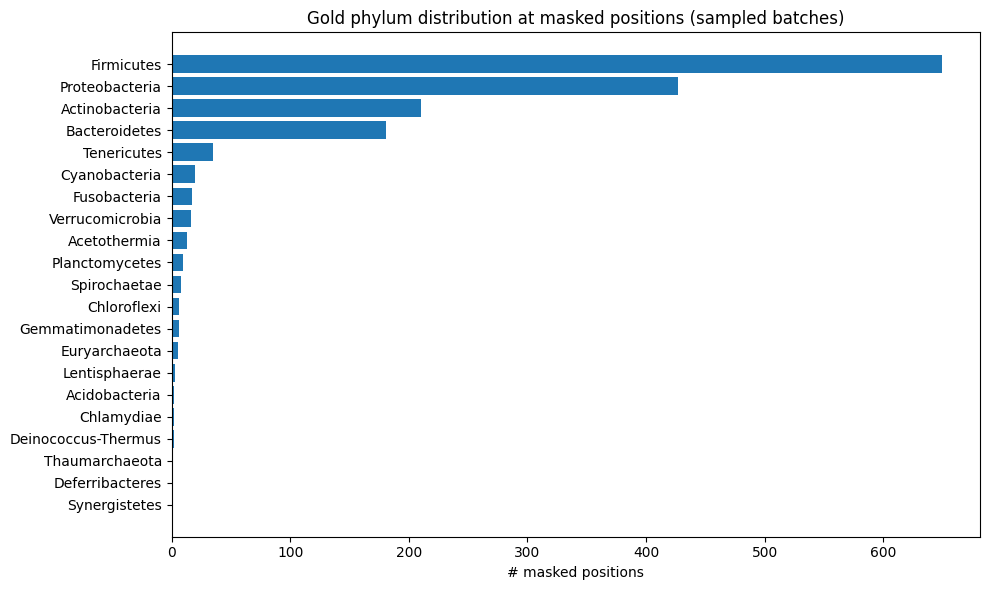

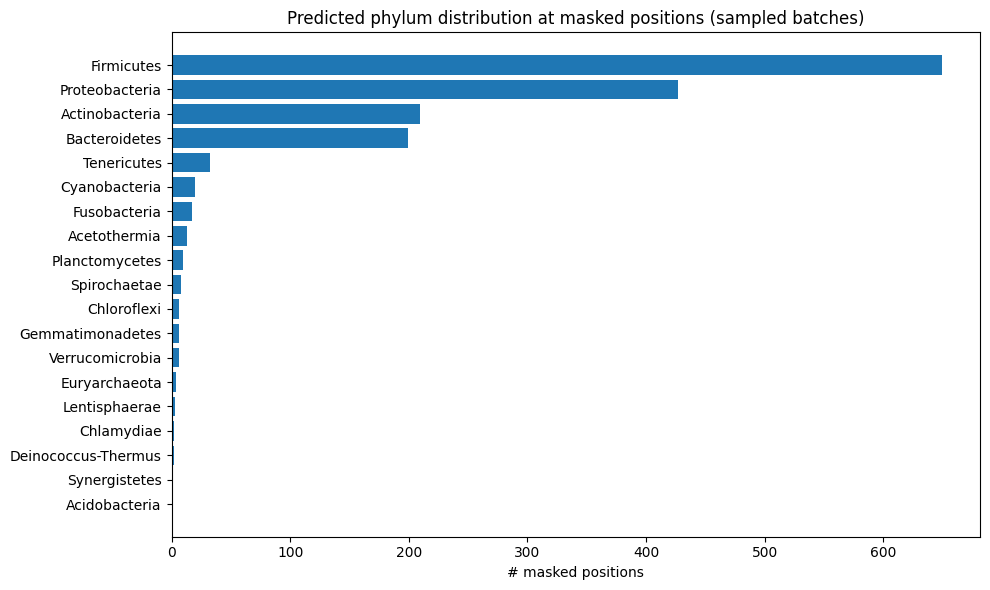

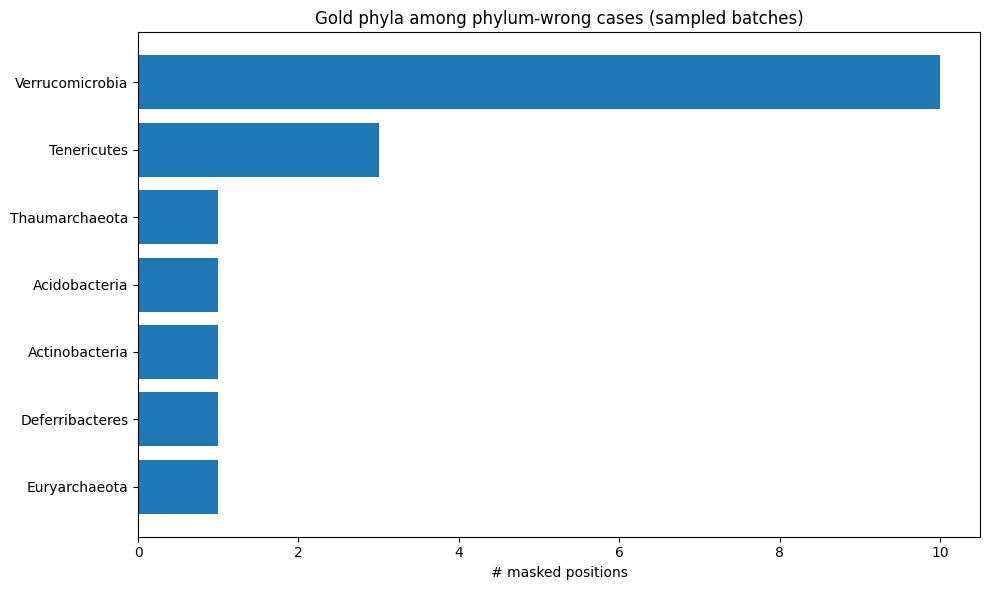

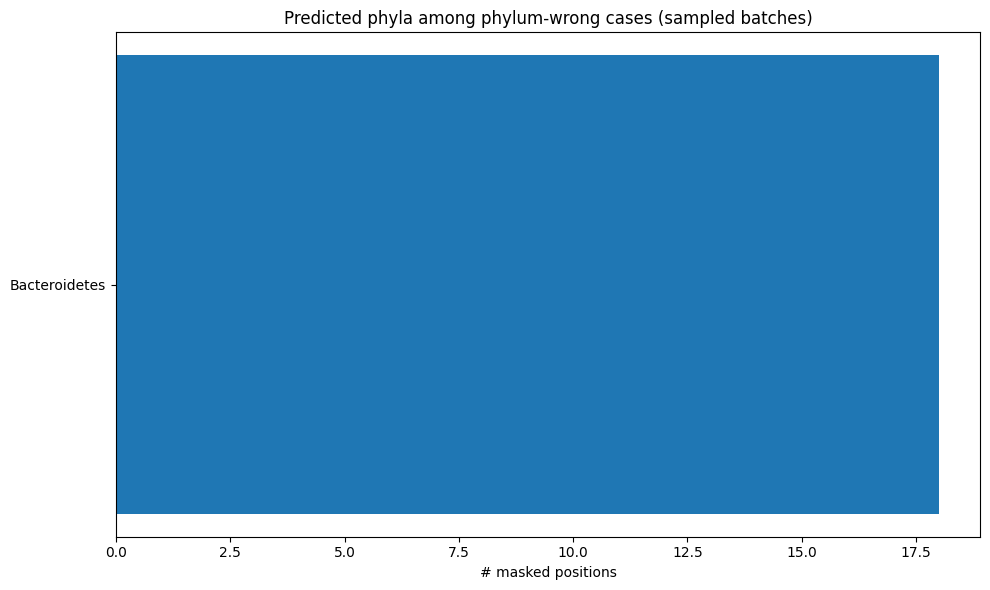

In [27]:
stats = sample_masked_phylum_distributions(
    dataset_subset=test_ds,
    collate_fn=collate,
    model=model,
    device=DEVICE,
    T_base=T_base,
    ancestor_at_rank_p=ancestor_at_rank["p"],  # from your build_ancestor_arrays_all_ranks
    tax_id2name=tax_id2name,
    M_dev=M_dev,
    rank_idx_dev=rank_idx_dev,
    hierarchical_predict_full_path=hierarchical_predict_full_path,
    n_batches=20,
    batch_size=64,
    seed=123,
    top_k=25,
)


# comparing results with the real predictions

In [36]:

RANKS = ("k","p","c","o","f","g","s")

def strip_rank_prefix(x: str) -> str:
    if not isinstance(x, str):
        return ""
    x = x.strip()
    if ":" in x:
        return x.split(":", 1)[1].strip()
    return x

def extract_pred_rank_name(pb, r: str) -> str:
    # pb is pred_by_rank dict
    if not isinstance(pb, dict):
        return ""
    rr = pb.get(r, None)
    if not isinstance(rr, dict):
        return ""
    name = rr.get("tax_name", "")
    return strip_rank_prefix(name)

pred_path = Path(OUT_JSONL_AFFECTED)  # set your affected JSONL here
dfp = pd.read_json(pred_path, lines=True)

# this must match SINTAX OTU id string
# (your JSONL already has otu_name)
dfp["otu_key"] = dfp["otu_name"].astype(str)

# predicted names per rank
for r in RANKS:
    dfp[f"pred_{r}_name"] = dfp["pred_by_rank"].apply(lambda d: extract_pred_rank_name(d, r))


In [37]:

true_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_all_OTUs/repseqs_sintax_v123.txt"

def load_sintax_table(path: str) -> pd.DataFrame:
    # tries common formats: (otu_id, ..., taxonomy) or (otu_id, raw_sintax)
    try:
        df = pd.read_csv(path, sep="\t", header=None, engine="python",
                         usecols=[0,3], names=["otu_id","taxonomy"], dtype=str)
    except Exception:
        df_raw = pd.read_csv(path, sep="\t", header=None, engine="python",
                             usecols=[0,1], names=["otu_id","raw_sintax"], dtype=str)
        def drop_conf(s):
            if pd.isna(s): return ""
            parts = [p.split("(",1)[0].strip() for p in s.strip().rstrip(";").split(",") if ":" in p]
            return ",".join(parts)
        df_raw["taxonomy"] = df_raw["raw_sintax"].apply(drop_conf)
        df = df_raw[["otu_id","taxonomy"]]
    df["taxonomy"] = df["taxonomy"].fillna("")
    return df

def parse_tax_to_cols(series: pd.Series) -> pd.DataFrame:
    ranks = ["k","p","c","o","f","g","s"]
    def to_dict(tax):
        out = {r:"" for r in ranks}
        for part in str(tax).strip().rstrip(";").split(","):
            if ":" not in part: 
                continue
            r, name = part.split(":", 1)
            r = r.strip()
            name = name.split("(", 1)[0].strip()
            if r in out:
                out[r] = name
        return pd.Series(out)
    return series.apply(to_dict)

true_df = load_sintax_table(true_path)
true_cols = parse_tax_to_cols(true_df["taxonomy"])

dft = pd.concat([true_df[["otu_id"]], true_cols], axis=1)
dft = dft.rename(columns={r: f"true_{r}_name" for r in RANKS})

# join key: OTU string id
dft["otu_key"] = dft["otu_id"].astype(str)


In [41]:

RANKS = ("k","p","c","o","f","g","s")

PRED_PATH = Path(OUT_JSONL_AFFECTED)   # or OUT_JSONL_RANDOM
dfp = pd.read_json(str(PRED_PATH), lines=True)

# Join key: prediction OTU string (matches true_df["otu_id"])
dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
print("[PRED] rows:", len(dfp), "| unique OTUs:", dfp["otu_key"].nunique())
print("[PRED] preview otu_key:", dfp["otu_key"].head(5).tolist())

dft["otu_key"] = dft["otu_key"].astype(str).str.strip()
print("[TRUE] rows:", len(dft), "| unique OTUs:", dft["otu_key"].nunique())
print("[TRUE] preview otu_key:", dft["otu_key"].head(5).tolist())



[PRED] rows: 24200 | unique OTUs: 683
[PRED] preview otu_key: ['90_21;96_37529;97_47711', '90_196;96_1788;97_2140', '90_15366;96_30286;97_38286', '90_21;96_37529;97_47711', '90_17668;96_69075;97_89749']
[TRUE] rows: 111870 | unique OTUs: 111870
[TRUE] preview otu_key: ['90_18938;96_79042;97_101874', '90_20463;96_79800;97_102794', '90_22156;96_86043;97_110485', '90_19327;96_77520;97_100055', '90_20463;96_79800;97_102793']


In [42]:
df_join = dfp.merge(
    dft.drop(columns=["otu_id"]),   # keep otu_key + true_*_name
    on="otu_key",
    how="left",
    validate="many_to_one"
)

missing = df_join["true_p_name"].isna().mean()
print(f"[JOIN] missing true taxonomy rows: {missing:.2%}")
print("[JOIN] rows:", len(df_join))


[JOIN] missing true taxonomy rows: 0.00%
[JOIN] rows: 24200


In [44]:
def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

for r in RANKS:
    df_join[f"pred_{r}_name"] = df_join["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

df_join[["otu_key", "true_p_name", "pred_p_name", "true_g_name", "pred_g_name"]].head(10)



,otu_key,true_p_name,pred_p_name,true_g_name,pred_g_name
0,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
1,90_196;96_1788;97_2140,Firmicutes,Firmicutes,Acetivibrio,Acetivibrio
2,90_15366;96_30286;97_38286,Bacteroidetes,Bacteroidetes,Sphingobacterium,Sphingobacterium
3,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
4,90_17668;96_69075;97_89749,Euryarchaeota,Euryarchaeota,Methanobrevibacter,Methanobrevibacter
5,90_224;96_3191;97_3915,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
6,90_224;96_3358;97_4119,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
7,90_7;96_1399;97_1670,Proteobacteria,Proteobacteria,Taylorella,Taylorella
8,90_11422;96_49727;97_64022,Firmicutes,Firmicutes,Weissella,Weissella
9,90_9;96_22874;97_28600,Actinobacteria,Actinobacteria,Arthrobacter,Arthrobacter


In [46]:
def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown", "__unknown"})

rows = []
for r in RANKS:
    gold = df_join[f"true_{r}_name"].fillna("").astype(str)
    pred = df_join[f"pred_{r}_name"].fillna("").astype(str)

    valid = ~gold.apply(_is_missing_name)
    n_eval = int(valid.sum())
    acc = float((pred[valid] == gold[valid]).mean()) if n_eval > 0 else float("nan")

    rows.append({"rank": r, "n_eval": n_eval, "acc_non_corrupted": acc})

acc_nc = pd.DataFrame(rows)
display(acc_nc)


,rank,n_eval,acc_non_corrupted
0,k,24200,0.999504
1,p,24200,0.965661
2,c,24200,0.963017
3,o,24200,0.941364
4,f,24200,0.948017
5,g,24198,0.912059
6,s,24200,0.000000


In [47]:
rank_index = {r: i for i, r in enumerate(RANKS)}

def rankACC_non_corrupted_row(row) -> float:
    # deepest available true rank in non-corrupted taxonomy
    deepest = None
    for r in reversed(RANKS):
        if not _is_missing_name(row.get(f"true_{r}_name", "")):
            deepest = r
            break
    if deepest is None:
        return float("nan")

    D = rank_index[deepest] + 1
    m = 0
    for r in RANKS[:D]:
        g = row.get(f"true_{r}_name", "")
        if _is_missing_name(g):
            continue
        p = row.get(f"pred_{r}_name", "")
        if p == g:
            m += 1
        else:
            break
    return float(m / max(1, D))

df_join["rankACC_non_corrupted"] = df_join.apply(rankACC_non_corrupted_row, axis=1)
print("[non-corrupted] Global rankACC (name-based):", float(df_join["rankACC_non_corrupted"].mean()))


[non-corrupted] Global rankACC (name-based): 0.8093860684769776


In [50]:


RANKS = ("k","p","c","o","f","g","s")

def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown","__unknown"})

def build_df_non_corrupted_gold(
    *,
    pred_jsonl_path,
    dft_true,               # your dft: columns otu_key + true_{r}_name
    ranks=RANKS,
):
    dfp = pd.read_json(str(Path(pred_jsonl_path)), lines=True)
    if dfp.empty:
        raise ValueError("Predictions JSONL is empty.")

    # join key (OTU string id)
    dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
    dft_true = dft_true.copy()
    dft_true["otu_key"] = dft_true["otu_key"].astype(str).str.strip()

    df = dfp.merge(
        dft_true.drop(columns=["otu_id"], errors="ignore"),
        on="otu_key",
        how="left",
        validate="many_to_one",
    )

    miss = df["true_p_name"].isna().mean()
    print(f"[JOIN] missing non-corrupted taxonomy rows: {miss:.2%}")

    # predictions as names per rank
    for r in ranks:
        df[f"pred_{r}"] = df["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

    # gold as names per rank (already in dft_true)
    for r in ranks:
        # ensure string, keep missing as ""
        df[f"gold_{r}"] = df.get(f"true_{r}_name", "").fillna("").astype(str)

    return df

# Use your affected JSONL here
df_nc = build_df_non_corrupted_gold(
    pred_jsonl_path=OUT_JSONL_AFFECTED,  # or OUT_JSONL_RANDOM
    dft_true=dft,                        # built from true_df taxonomy (non-corrupted)
    ranks=RANKS,
)

df_nc[["otu_key","gold_p","pred_p","gold_g","pred_g"]].head(10)




[JOIN] missing non-corrupted taxonomy rows: 0.00%


,otu_key,gold_p,pred_p,gold_g,pred_g
0,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
1,90_196;96_1788;97_2140,Firmicutes,Firmicutes,Acetivibrio,Acetivibrio
2,90_15366;96_30286;97_38286,Bacteroidetes,Bacteroidetes,Sphingobacterium,Sphingobacterium
3,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
4,90_17668;96_69075;97_89749,Euryarchaeota,Euryarchaeota,Methanobrevibacter,Methanobrevibacter
5,90_224;96_3191;97_3915,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
6,90_224;96_3358;97_4119,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
7,90_7;96_1399;97_1670,Proteobacteria,Proteobacteria,Taylorella,Taylorella
8,90_11422;96_49727;97_64022,Firmicutes,Firmicutes,Weissella,Weissella
9,90_9;96_22874;97_28600,Actinobacteria,Actinobacteria,Arthrobacter,Arthrobacter


In [53]:
df_nc.keys()

Index(['sample_id', 'position', 'otu_id', 'otu_name', 'true_tax_id',
       'true_tax_name', 'pred_flat', 'pred_by_rank', 'experiment_tag',
       'otu_key', 'true_k_name', 'true_p_name', 'true_c_name', 'true_o_name',
       'true_f_name', 'true_g_name', 'true_s_name', 'pred_k', 'pred_p',
       'pred_c', 'pred_o', 'pred_f', 'pred_g', 'pred_s', 'gold_k', 'gold_p',
       'gold_c', 'gold_o', 'gold_f', 'gold_g', 'gold_s'],
      dtype='object')

In [56]:
def ensure_ok_columns_names(df, ranks=RANKS):
    df = df.copy()
    for r in ranks:
        g = df[f"gold_{r}"].fillna("").astype(str)
        p = df[f"pred_{r}"].fillna("").astype(str)

        has = ~g.apply(_is_missing_name)
        ok = pd.Series(np.nan, index=df.index, dtype="float")
        ok.loc[has] = (p.loc[has].to_numpy() == g.loc[has].to_numpy()).astype(float)
        df[f"ok_{r}"] = ok
    return df

def deepest_gold_rank_names(row, ranks=RANKS):
    for r in reversed(ranks):
        if not _is_missing_name(row.get(f"gold_{r}", "")):
            return r
    return None

def first_wrong_rank_up_to_target(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if (not pd.isna(ok)) and (ok < 0.5):
            return r
    return None

def rankACC_for_row_names(row, target_rank, ranks=RANKS):
    D = ranks.index(target_rank) + 1
    m = 0
    for r in ranks[:D]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if pd.isna(ok):
            continue
        if ok >= 0.5:
            m += 1
        else:
            break
    return float(m / max(1, D))

def strict_error_origin_matrix_and_rankACC_names(df, ranks=RANKS):
    df2 = ensure_ok_columns_names(df, ranks=ranks).copy()

    df2["deepest_rank"] = df2.apply(lambda row: deepest_gold_rank_names(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    counts = pd.DataFrame(0, index=ranks, columns=ranks, dtype=int)
    meta_rows = []

    for target in ranks:
        sub = df2[df2["deepest_rank"] == target].copy()
        n_preds = int(len(sub))

        if n_preds == 0:
            meta_rows.append({
                "rank": target,
                "n_preds_strict": 0,
                "n_errors_strict": 0,
                "strict_error_rate": np.nan,
                "rankACC_mean": np.nan,
            })
            continue

        sub["rankACC"] = sub.apply(lambda row: rankACC_for_row_names(row, target, ranks=ranks), axis=1)
        rankACC_mean = float(sub["rankACC"].mean())

        err_mask = sub["rankACC"] < 0.999999
        errs = sub[err_mask].copy()
        n_errors = int(len(errs))

        if n_errors > 0:
            errs["first_wrong"] = errs.apply(
                lambda row: first_wrong_rank_up_to_target(row, target, ranks=ranks),
                axis=1
            )
            vc = errs["first_wrong"].value_counts(dropna=True)
            for col_rank, cnt in vc.items():
                counts.loc[target, col_rank] = int(cnt)

        meta_rows.append({
            "rank": target,
            "n_preds_strict": n_preds,
            "n_errors_strict": n_errors,
            "strict_error_rate": float(n_errors / max(1, n_preds)),
            "rankACC_mean": rankACC_mean,
        })

    meta = pd.DataFrame(meta_rows).set_index("rank")
    return counts, meta, df2

counts_nc, meta_nc, df_nc2 = strict_error_origin_matrix_and_rankACC_names(df_nc, ranks=RANKS)
display(meta_nc)


,n_preds_strict,n_errors_strict,strict_error_rate,rankACC_mean
rank,,,,
k,0,0,NaN,NaN
p,0,0,NaN,NaN
c,0,0,NaN,NaN
o,0,0,NaN,NaN
f,0,0,NaN,NaN
g,0,0,NaN,NaN
s,24200,24200,1.0,0.809386


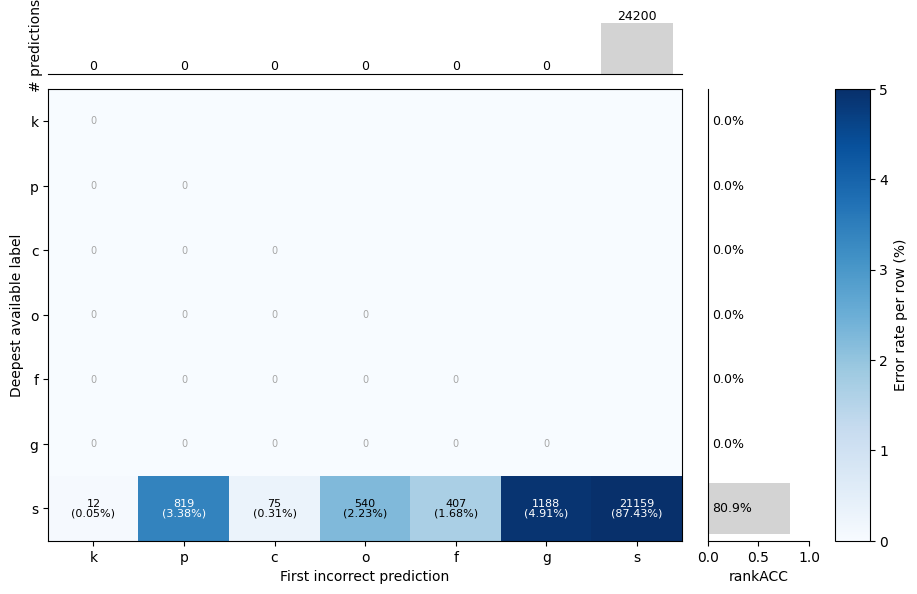

In [109]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_nc,
    meta_nc,
    title="",#"Error-origin matrix with rankACC (TEST, affected OTUs) — non-corrupted SILVA gold",
    ranks=RANKS,
    df=df_nc2,                 # to show OTUs and N predictions
    otu_col="otu_id",          # or "otu_key"; your df has otu_key (string) and otu_id (numeric)
    show_zeros_lower=True,
    show_percent_text=True,
    vmax_pct=5.0,
    vmin_pct=0.0,
)


# cheking wrong predictions "Real" Taxonomy label

In [58]:
RANKS = ["k","p","c","o","f","g","s"]

for r in RANKS:
    df_nc[f"ok_{r}"] = df_nc[f"pred_{r}"] == df_nc[f"gold_{r}"]
def summarize_rank_errors(df, rank, topk=10):
    sub = df[~df[f"ok_{rank}"]].copy()
    if sub.empty:
        return None

    tbl = (
        sub.groupby([f"gold_{rank}", f"pred_{rank}"])
           .size()
           .reset_index(name="count")
           .sort_values("count", ascending=False)
           .head(topk)
    )
    return tbl
for r in RANKS:
    tbl = summarize_rank_errors(df_nc, r, topk=8)
    if tbl is not None:
        print(f"\n=== Top {r.upper()} confusions ===")
        display(tbl)



=== Top K confusions ===


,gold_k,pred_k,count
0,Archaea,Bacteria,12



=== Top P confusions ===


,gold_p,pred_p,count
16,Firmicutes,Tenericutes,358
0,Acidobacteria,Acetothermia,161
30,Verrucomicrobia,Bacteroidetes,95
17,Firmicutes,UNK,42
2,Actinobacteria,Bacteroidetes,29
20,Proteobacteria,Bacteroidetes,24
19,Proteobacteria,Acetothermia,21
26,Tenericutes,Bacteroidetes,16



=== Top C confusions ===


,gold_c,pred_c,count
34,Erysipelotrichia,Mollicutes,204
1,Acidobacteria,Unknown_Class,161
15,Clostridia,Mollicutes,154
61,Verrucomicrobiae,Flavobacteriia,85
9,Bacilli,Clostridia,48
16,Clostridia,UNK,42
35,Gammaproteobacteria,Bacteroidia,19
2,Actinobacteria,Bacteroidia,17



=== Top O confusions ===


,gold_o,pred_o,count
76,SubsectionIII,SubsectionII,219
42,Erysipelotrichales,Entomoplasmatales,204
34,Clostridiales,Entomoplasmatales,154
9,Aeromonadales,UNK,86
72,Subgroup_4,Unknown_Order,85
90,Verrucomicrobiales,Flavobacteriales,85
71,Subgroup_3,Unknown_Order,76
77,SubsectionIV,SubsectionII,65



=== Top F confusions ===


,gold_f,pred_f,count
45,Erysipelotrichaceae,Entomoplasmataceae,204
83,Rhizobiales_Incertae_Sedis,UNK,197
65,Lachnospiraceae,Entomoplasmataceae,154
11,Aeromonadaceae,UNK,86
88,Rubritaleaceae,Flavobacteriaceae,57
74,Peptostreptococcaceae,UNK,42
36,Colwelliaceae,Enterobacteriaceae,39
92,Sanguibacteraceae,UNK,34



=== Top G confusions ===


,gold_g,pred_g,count
105,Luteimonas,UNK,257
136,Phreatobacter,UNK,197
8,Actinobacillus,UNK,89
12,Aeromonas,UNK,86
74,Gemmatimonas,UNK,86
160,Rubritalea,UNK,64
106,Luteolibacter,UNK,48
87,Intestinibacter,UNK,42



=== Top S confusions ===


,gold_s,pred_s,count
631,unidentified,UNK,5754
460,Ralstonia_solanacearum,UNK,734
206,Faecalitalea_cylindroides,UNK,625
155,Clostridium_sp._TM-40,UNK,600
209,Filimonas_sp._5GHs7-2,UNK,481
90,Bifidobacterium_choerinum,Bifidobacterium_choerinum_DSM_20434,366
624,unidentified,Eubacterium_coprostanoligenes,308
364,Nocardioides_islandensis,UNK,303


In [74]:
pd.set_option("display.max_colwidth", None)

RANKS = ["k","p","c","o","f","g","s"]

def summarize_rank_errors_with_context(
    df: pd.DataFrame,
    rank: str,
    topk: int = 10,
    otu_col: str = "otu_key",   # change if your OTU id column is different
):
    """
    Top confusion pairs at a given rank with:
      - count: number of prediction rows
      - n_otus: number of unique OTUs contributing
      - gold_lineage: k→...→rank lineage for the gold label (from a representative row)
      - pred_lineage: k→...→rank lineage for the predicted label (from a representative row)
    """
    ok_col = f"ok_{rank}"
    if ok_col not in df.columns:
        raise KeyError(f"Missing {ok_col}. Compute ok_{rank} first.")

    sub = df[~df[ok_col]].copy()
    if sub.empty:
        return None

    gcols = [f"gold_{rank}", f"pred_{rank}"]

    # 1) counts + unique OTUs per confusion pair
    base = (
        sub.groupby(gcols, dropna=False)
           .agg(
               count=(otu_col, "size"),
               n_otus=(otu_col, pd.Series.nunique),
           )
           .reset_index()
    )

    # 2) pick one representative row per confusion pair (for lineage strings)
    first_rows = (
        sub.sort_index()
           .groupby(gcols, dropna=False)
           .head(1)
           .copy()
    )

    r_idx = RANKS.index(rank)
    ranks_upto = RANKS[: r_idx + 1]

    def _lineage(row, prefix: str):
        parts = []
        for r in ranks_upto:
            col = f"{prefix}_{r}"
            val = row.get(col, None)
            if val is None or (isinstance(val, float) and pd.isna(val)):
                continue
            val = str(val).strip()
            if val == "":
                continue
            parts.append(f"{r}:{val}")
        return "; ".join(parts)

    first_rows["gold_lineage"] = first_rows.apply(lambda row: _lineage(row, "gold"), axis=1)
    first_rows["pred_lineage"] = first_rows.apply(lambda row: _lineage(row, "pred"), axis=1)

    ctx = first_rows[gcols + ["gold_lineage", "pred_lineage"]]

    # 3) merge + sort
    tbl = (
        base.merge(ctx, on=gcols, how="left")
            .sort_values("count", ascending=False)
            .head(topk)
            .reset_index(drop=True)
    )
    return tbl


# Example usage (species)
tbl_s = summarize_rank_errors_with_context(df_nc, "s", topk=12, otu_col="otu_key")
display(tbl_s)


,gold_s,pred_s,count,n_otus,gold_lineage,pred_lineage
0,unidentified,UNK,5754,48,k:Bacteria; p:Bacteroidetes; c:Bacteroidia; o:Bacteroidales; f:Bacteroidaceae; g:Bacteroides; s:unidentified,k:Bacteria; p:Bacteroidetes; c:Bacteroidia; o:Bacteroidales; f:Bacteroidaceae; g:Bacteroides; s:UNK
1,Ralstonia_solanacearum,UNK,734,1,k:Bacteria; p:Proteobacteria; c:Betaproteobacteria; o:Burkholderiales; f:Burkholderiaceae; g:Ralstonia; s:Ralstonia_solanacearum,k:Bacteria; p:Proteobacteria; c:Betaproteobacteria; o:Burkholderiales; f:Burkholderiaceae; g:Ralstonia; s:UNK
2,Faecalitalea_cylindroides,UNK,625,2,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Faecalitalea; s:Faecalitalea_cylindroides,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Faecalitalea; s:UNK
3,Clostridium_sp._TM-40,UNK,600,1,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Erysipelatoclostridium; s:Clostridium_sp._TM-40,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Erysipelatoclostridium; s:UNK
4,Filimonas_sp._5GHs7-2,UNK,481,1,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Chitinophagaceae; g:Parafilimonas; s:Filimonas_sp._5GHs7-2,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Chitinophagaceae; g:Parafilimonas; s:UNK
5,Bifidobacterium_choerinum,Bifidobacterium_choerinum_DSM_20434,366,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Bifidobacteriales; f:Bifidobacteriaceae; g:Bifidobacterium; s:Bifidobacterium_choerinum,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Bifidobacteriales; f:Bifidobacteriaceae; g:Bifidobacterium; s:Bifidobacterium_choerinum_DSM_20434
6,unidentified,Eubacterium_coprostanoligenes,308,1,k:Bacteria; p:Firmicutes; c:Clostridia; o:Clostridiales; f:Ruminococcaceae; g:[Eubacterium]_coprostanoligenes_group; s:unidentified,k:Bacteria; p:Firmicutes; c:Clostridia; o:Clostridiales; f:Ruminococcaceae; g:[Eubacterium]_coprostanoligenes_group; s:Eubacterium_coprostanoligenes
7,Nocardioides_islandensis,UNK,303,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Propionibacteriales; f:Nocardioidaceae; g:Nocardioides; s:Nocardioides_islandensis,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Propionibacteriales; f:Nocardioidaceae; g:Nocardioides; s:UNK
8,Pedobacter_insulae,UNK,296,1,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Sphingobacteriaceae; g:Pedobacter; s:Pedobacter_insulae,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Sphingobacteriaceae; g:Pedobacter; s:UNK
9,Corynebacterium_glutamicum,UNK,290,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Corynebacteriales; f:Corynebacteriaceae; g:Corynebacterium_1; s:Corynebacterium_glutamicum,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Corynebacteriales; f:Corynebacteriaceae; g:Corynebacterium_1; s:UNK


In [78]:
df_nc.keys()

Index(['sample_id', 'position', 'otu_id', 'otu_name', 'true_tax_id',
       'true_tax_name', 'pred_flat', 'pred_by_rank', 'experiment_tag',
       'otu_key', 'true_k_name', 'true_p_name', 'true_c_name', 'true_o_name',
       'true_f_name', 'true_g_name', 'true_s_name', 'pred_k', 'pred_p',
       'pred_c', 'pred_o', 'pred_f', 'pred_g', 'pred_s', 'gold_k', 'gold_p',
       'gold_c', 'gold_o', 'gold_f', 'gold_g', 'gold_s', 'has_k', 'has_p',
       'has_c', 'has_o', 'has_f', 'has_g', 'has_s', 'deepest_rank_nc', 'ok_k',
       'ok_p', 'ok_c', 'ok_o', 'ok_f', 'ok_g', 'ok_s', 'species_error_type',
       'deepest_rank', 'first_wrong'],
      dtype='object')

In [75]:
n_otus_unidentified = (
    df_nc.loc[df_nc["gold_s"] == "unidentified", "otu_key"]
    .nunique()
)

print(f"Unique OTUs with gold_s == 'unidentified': {n_otus_unidentified}")


Unique OTUs with gold_s == 'unidentified': 56


In [80]:
cols = ["otu_key", "gold_k", "gold_p", "gold_c", "gold_o", "gold_f", "gold_g", "gold_s", "pred_s"]

display(
    df_nc[df_nc["gold_s"] == "unidentified"][cols]
    .drop_duplicates()
    .head(25)
)
#df_nc.loc[df_nc["gold_s"] == "unidentified", "otu_key"]

,otu_key,gold_k,gold_p,gold_c,gold_o,gold_f,gold_g,gold_s,pred_s
0,90_21;96_37529;97_47711,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unidentified,UNK
1,90_196;96_1788;97_2140,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Acetivibrio,unidentified,UNK
12,90_4;96_54881;97_70780,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,unidentified,Streptococcus_sp._oral_clone_ASCG04
14,90_507;96_3340;97_4097,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Holdemania,unidentified,UNK
25,90_807;96_6715;97_8192,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae_UCG-014,unidentified,UNK
36,90_523;96_10716;97_12955,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,unidentified,UNK
37,90_15868;96_15327;97_18743,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,unidentified,UNK
38,90_229;96_1066;97_1244,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,unidentified,UNK
45,90_635;96_18530;97_22911,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Filifactor,unidentified,Filifactor_villosus
90,90_3936;96_24692;97_30918,Bacteria,Proteobacteria,Deltaproteobacteria,Bdellovibrionales,Bdellovibrionaceae,Bdellovibrio,unidentified,UNK


In [67]:
RANKS = ("k","p","c","o","f","g","s")

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
for r in RANKS:
    c = f"ok_{r}"
    if c not in df_nc.columns:
        raise KeyError(f"df_nc is missing {c}. You need ok_* columns computed first.")
    # convert from {0/1, True/False, nan} -> bool (nan treated as False here)
    df_nc[c] = df_nc[c].fillna(False).astype(bool)

# -----------------------------
# 1) Add deepest_rank and (optional) first_wrong to df_nc
# -----------------------------
def _deepest_rank_from_gold(row, ranks=RANKS):
    # gold_* are strings here (names). If empty/None => missing.
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", None)
        if v is not None and str(v).strip() != "":
            return r
    return None

def _first_wrong_rank_up_to_target_from_ok(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        v = row.get(f"gold_{r}", None)
        if v is None or str(v).strip() == "":
            continue
        if not bool(row.get(f"ok_{r}", False)):
            return r
    return None

df_nc = df_nc.copy()
df_nc["deepest_rank"] = df_nc.apply(_deepest_rank_from_gold, axis=1)

# Optional: first_wrong (not strictly required for your requested %)
df_nc["first_wrong"] = df_nc.apply(
    lambda row: _first_wrong_rank_up_to_target_from_ok(row, row["deepest_rank"], ranks=RANKS)
    if row["deepest_rank"] in RANKS else None,
    axis=1
)

# -----------------------------
# 2) Helpers: clean + compare species strings
# -----------------------------
def _clean_species_name(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")

    s = re.sub(
        r"(_(DSM|ATCC|JCM|CCUG|CIP|LMG|NCTC|NBRC|KCTC|IFO|NRRL|MTCC|CGMCC|CECT|BCCM|ICMP|TISTR|TTC|VKPM|KMM|BCRC|NCIMB|GDMCC|CCTCC|GCA|GCF)_?.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(
        r"(_(strain|str|isolate|isln|clone|cl|sample|bacterium|metagenome)_.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _split_genus_species(cleaned: str):
    if not cleaned:
        return ("", "")
    parts = cleaned.split("_")
    if len(parts) < 2:
        return (parts[0], "")
    return (parts[0], parts[1])

def classify_species_only_error(row):
    pred_s = row.get("pred_s", None)
    gold_s = row.get("gold_s", None)

    # 1) explicit UNK / empty
    if pred_s is None:
        return "UNK_species"
    if "UNK" in str(pred_s).upper():
        return "UNK_species"
    if str(pred_s).strip() == "":
        return "UNK_species"

    gold_clean = _clean_species_name(gold_s)
    pred_clean = _clean_species_name(pred_s)

    # 2) genus-correct cases
    if row.get("pred_g", None) == row.get("gold_g", None):
        if gold_clean and pred_clean and (gold_clean.lower() == pred_clean.lower()):
            return "Closest_species"
        g1, e1 = _split_genus_species(gold_clean)
        g2, e2 = _split_genus_species(pred_clean)
        if g1 and g2 and (g1.lower() == g2.lower()) and e1 and e2 and (e1.lower() == e2.lower()):
            return "Closest_species"
        return "Other_species_same_genus"

    # 3) family-correct, genus-wrong
    if row.get("pred_f", None) == row.get("gold_f", None):
        return "Same_family"

    return "Farther_than_family"

# -----------------------------
# 3) Subset: species-only error rows
#    (deepest must be species, all ok up to genus, species wrong)
# -----------------------------
species_only_error = (
    (df_nc["deepest_rank"] == "s") &
    df_nc["ok_k"] & df_nc["ok_p"] & df_nc["ok_c"] &
    df_nc["ok_o"] & df_nc["ok_f"] & df_nc["ok_g"] &
    (~df_nc["ok_s"])
)

df_species_only = df_nc[species_only_error].copy()
df_species_only["species_error_mode"] = df_species_only.apply(classify_species_only_error, axis=1)

# -----------------------------
# 4) NEW %: denominator = ALL species-row predictions (matches your plot row denominator)
# -----------------------------
n_preds_species_row = int((df_nc["deepest_rank"] == "s").sum())
if n_preds_species_row <= 0:
    raise ValueError("No rows with deepest_rank == 's' found; cannot compute row-based percentages.")

mode_counts = df_species_only["species_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_all_species_row_preds"] = (100.0 * mode_counts["count"] / n_preds_species_row).round(2)

display(mode_counts)

print(
    "[CHECK] species-row denom =", n_preds_species_row,
    "| n_species_only =", len(df_species_only),
    "| sum pct_of_all_species_row_preds =",
    float(mode_counts["pct_of_all_species_row_preds"].sum()),
    "| expected to be <= (s,s) cell % from matrix"
)

# Examples (Closest species)
cols = ["otu_key", "gold_g", "pred_g", "gold_s", "pred_s"]
display(df_species_only[df_species_only["species_error_mode"] == "Closest_species"].head(25)[cols])


,count,pct_of_all_species_row_preds
species_error_mode,,
UNK_species,18225,75.31
Closest_species,1515,6.26
Other_species_same_genus,1418,5.86


[CHECK] species-row denom = 24200 | n_species_only = 21158 | sum pct_of_all_species_row_preds = 87.43 | expected to be <= (s,s) cell % from matrix


,otu_key,gold_g,pred_g,gold_s,pred_s
5,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333
7,90_7;96_1399;97_1670,Taylorella,Taylorella,Taylorella_asinigenitalis,Taylorella_asinigenitalis_14/45
32,90_12;96_1719;97_2058,Burkholderia,Burkholderia,Burkholderia_andropogonis,Burkholderia_andropogonis_Ba3549
41,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
44,90_507;96_24462;97_30625,[Anaerorhabdus]_furcosa_group,[Anaerorhabdus]_furcosa_group,Erysipelotrichaceae_bacterium_canine_oral_taxo...,Erysipelotrichaceae_bacterium_feline_oral_taxo...
56,90_292;96_1143;97_1341,Novispirillum,Novispirillum,Rhodospirillaceae_bacterium_H6167,Rhodospirillaceae_bacterium_H6172
89,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
97,90_143;96_2090;97_2518,Desulfotalea,Desulfotalea,Desulfotalea_psychrophila_LSv54,Desulfotalea_psychrophila
110,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
143,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B


In [ ]:
RANKS = ("k","p","c","o","f","g","s")

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
for r in RANKS:
    c = f"ok_{r}"
    if c not in df_nc.columns:
        raise KeyError(f"df_nc is missing {c}. You need ok_* columns computed first.")
    # convert from {0/1, True/False, nan} -> bool (nan treated as False here)
    df_nc[c] = df_nc[c].fillna(False).astype(bool)

# -----------------------------
# 1) Add deepest_rank and (optional) first_wrong to df_nc
# -----------------------------
def _deepest_rank_from_gold(row, ranks=RANKS):
    # gold_* are strings here (names). If empty/None => missing.
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", None)
        if v is not None and str(v).strip() != "":
            return r
    return None

def _first_wrong_rank_up_to_target_from_ok(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        v = row.get(f"gold_{r}", None)
        if v is None or str(v).strip() == "":
            continue
        if not bool(row.get(f"ok_{r}", False)):
            return r
    return None

df_nc = df_nc.copy()
df_nc["deepest_rank"] = df_nc.apply(_deepest_rank_from_gold, axis=1)

# Optional: first_wrong (not strictly required for your requested %)
df_nc["first_wrong"] = df_nc.apply(
    lambda row: _first_wrong_rank_up_to_target_from_ok(row, row["deepest_rank"], ranks=RANKS)
    if row["deepest_rank"] in RANKS else None,
    axis=1
)

# -----------------------------
# 2) Helpers: clean + compare species strings
# -----------------------------
def _clean_species_name(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")

    s = re.sub(
        r"(_(DSM|ATCC|JCM|CCUG|CIP|LMG|NCTC|NBRC|KCTC|IFO|NRRL|MTCC|CGMCC|CECT|BCCM|ICMP|TISTR|TTC|VKPM|KMM|BCRC|NCIMB|GDMCC|CCTCC|GCA|GCF)_?.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(
        r"(_(strain|str|isolate|isln|clone|cl|sample|bacterium|metagenome)_.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _split_genus_species(cleaned: str):
    if not cleaned:
        return ("", "")
    parts = cleaned.split("_")
    if len(parts) < 2:
        return (parts[0], "")
    return (parts[0], parts[1])

def classify_species_only_error(row):
    pred_s = row.get("pred_s", None)
    gold_s = row.get("gold_s", None)

    # 1) explicit UNK / empty
    if pred_s is None:
        return "UNK_species"
    if "UNK" in str(pred_s).upper():
        return "UNK_species"
    if str(pred_s).strip() == "":
        return "UNK_species"

    gold_clean = _clean_species_name(gold_s)
    pred_clean = _clean_species_name(pred_s)

    # 2) genus-correct cases
    if row.get("pred_g", None) == row.get("gold_g", None):
        if gold_clean and pred_clean and (gold_clean.lower() == pred_clean.lower()):
            return "Closest_species"
        g1, e1 = _split_genus_species(gold_clean)
        g2, e2 = _split_genus_species(pred_clean)
        if g1 and g2 and (g1.lower() == g2.lower()) and e1 and e2 and (e1.lower() == e2.lower()):
            return "Closest_species"
        return "Other_species_same_genus"

    # 3) family-correct, genus-wrong
    if row.get("pred_f", None) == row.get("gold_f", None):
        return "Same_family"

    return "Farther_than_family"

# -----------------------------
# 3) Subset: species-only error rows
#    (deepest must be species, all ok up to genus, species wrong)
# -----------------------------
species_only_error = (
    (df_nc["deepest_rank"] == "s") &
    df_nc["ok_k"] & df_nc["ok_p"] & df_nc["ok_c"] &
    df_nc["ok_o"] & df_nc["ok_f"] & df_nc["ok_g"] &
    (~df_nc["ok_s"])
)

df_species_only = df_nc[species_only_error].copy()
df_species_only["species_error_mode"] = df_species_only.apply(classify_species_only_error, axis=1)

# -----------------------------
# 4) NEW %: denominator = ALL species-row predictions (matches your plot row denominator)
# -----------------------------
n_preds_species_row = int((df_nc["deepest_rank"] == "s").sum())
if n_preds_species_row <= 0:
    raise ValueError("No rows with deepest_rank == 's' found; cannot compute row-based percentages.")

mode_counts = df_species_only["species_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_all_species_row_preds"] = (100.0 * mode_counts["count"] / n_preds_species_row).round(2)

display(mode_counts)

print(
    "[CHECK] species-row denom =", n_preds_species_row,
    "| n_species_only =", len(df_species_only),
    "| sum pct_of_all_species_row_preds =",
    float(mode_counts["pct_of_all_species_row_preds"].sum()),
    "| expected to be <= (s,s) cell % from matrix"
)

# Examples (Closest species)
cols = ["otu_key", "gold_g", "pred_g", "gold_s", "pred_s"]
display(df_species_only[df_species_only["species_error_mode"] == "Closest_species"].head(25)[cols])


,count,pct_of_all_species_row_preds
species_error_mode,,
UNK_species,18225,75.31
Closest_species,1515,6.26
Other_species_same_genus,1418,5.86


[CHECK] species-row denom = 24200 | n_species_only = 21158 | sum pct_of_all_species_row_preds = 87.43 | expected to be <= (s,s) cell % from matrix


,otu_key,gold_g,pred_g,gold_s,pred_s
5,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333
7,90_7;96_1399;97_1670,Taylorella,Taylorella,Taylorella_asinigenitalis,Taylorella_asinigenitalis_14/45
32,90_12;96_1719;97_2058,Burkholderia,Burkholderia,Burkholderia_andropogonis,Burkholderia_andropogonis_Ba3549
41,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
44,90_507;96_24462;97_30625,[Anaerorhabdus]_furcosa_group,[Anaerorhabdus]_furcosa_group,Erysipelotrichaceae_bacterium_canine_oral_taxo...,Erysipelotrichaceae_bacterium_feline_oral_taxo...
56,90_292;96_1143;97_1341,Novispirillum,Novispirillum,Rhodospirillaceae_bacterium_H6167,Rhodospirillaceae_bacterium_H6172
89,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
97,90_143;96_2090;97_2518,Desulfotalea,Desulfotalea,Desulfotalea_psychrophila_LSv54,Desulfotalea_psychrophila
110,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
143,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B


In [68]:
def is_unidentified(s):
    if s is None:
        return False
    s = str(s).lower()
    return (
        "unidentified" in s
        or s.strip() in {"", "na", "nan"}
    )

mask_unidentified = df_nc["gold_s"].apply(is_unidentified)
df_unid = df_nc[mask_unidentified].copy()

print(f"Rows with gold_s unidentified: {len(df_unid):,}")
print(f"Unique OTUs involved: {df_unid['otu_key'].nunique():,}")
otu_counts = (
    df_unid["otu_key"]
    .value_counts()
    .to_frame("row_count")
)

display(otu_counts.head(10))

print("Top OTU share:",
      otu_counts.iloc[0, 0] / len(df_unid) * 100, "%")
cols_tax = ["gold_k","gold_p","gold_c","gold_o","gold_f","gold_g","gold_s"]

tax_depth_summary = {}
for r in cols_tax:
    tax_depth_summary[r] = (
        df_unid[r].notna() & (df_unid[r] != "")
    ).mean() * 100

pd.DataFrame.from_dict(
    tax_depth_summary, orient="index", columns=["percent_present"]
)


Rows with gold_s unidentified: 6,549
Unique OTUs involved: 64


,row_count
otu_key,
90_507;96_3340;97_4097,1015
90_807;96_10715;97_12952,484
90_229;96_1066;97_1244,446
90_4685;96_21513;97_51693,378
90_807;96_18367;97_22687,331
90_782;96_8582;97_10324,308
90_16;96_6842;97_8196,302
90_21;96_37529;97_47711,288
90_807;96_6715;97_8192,257


Top OTU share: 15.498549396854482 %


,percent_present
gold_k,100.0
gold_p,100.0
gold_c,100.0
gold_o,100.0
gold_f,100.0
gold_g,100.0
gold_s,100.0


In [69]:
pred_s_summary = (
    df_unid["pred_s"]
    .fillna("None")
    .value_counts()
    .to_frame("count")
)

display(pred_s_summary.head(15))
print("Unique predicted species:",
      df_unid["pred_s"].nunique())
otu_behavior = (
    df_unid
    .groupby("otu_key")
    .agg(
        n_rows=("otu_key", "size"),
        gold_g=("gold_g", "first"),
        pred_s_mode=("pred_s", lambda x: x.value_counts().idxmax()),
        pred_s_unique=("pred_s", "nunique"),
    )
    .sort_values("n_rows", ascending=False)
)

display(otu_behavior.head(10))


,count
pred_s,
UNK,5925
Eubacterium_coprostanoligenes,308
Kandleria_vitulina,116
Capnocytophaga_sp._oral_clone_ASCH05,75
Filifactor_villosus,49
Nocardioides_sp._PD653,22
Streptococcus_sp._oral_clone_ASCG04,19
Bdellovibrio_sp._MPA,17
Alkaliphilus_metalliredigens,8


Unique predicted species: 11


,n_rows,gold_g,pred_s_mode,pred_s_unique
otu_key,,,,
90_507;96_3340;97_4097,1015,Holdemania,UNK,1
90_807;96_10715;97_12952,484,Ruminococcaceae_UCG-014,UNK,1
90_229;96_1066;97_1244,446,Ruminiclostridium_5,UNK,1
90_4685;96_21513;97_51693,378,Desulfovibrio,UNK,1
90_807;96_18367;97_22687,331,Ruminococcaceae_UCG-014,UNK,1
90_782;96_8582;97_10324,308,[Eubacterium]_coprostanoligenes_group,Eubacterium_coprostanoligenes,1
90_16;96_6842;97_8196,302,Lachnoclostridium,UNK,1
90_21;96_37529;97_47711,288,Bacteroides,UNK,1
90_807;96_6715;97_8192,257,Ruminococcaceae_UCG-014,UNK,1
